<a href="https://colab.research.google.com/github/beksg00/ANLY-530/blob/main/ANLY530_LateFall2024_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install required libraries
!pip install --quiet xgboost lightgbm catboost scikit-learn numpy matplotlib pandas

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Set seed for reproducibility
SEED = 292001

# Load dataset (Ensure the file is uploaded to Google Colab)
file_path = "diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

# Balance the dataset using downsampling
min_class_size = df["Diabetes_012"].value_counts().min()
df_balanced = df.groupby("Diabetes_012").apply(lambda x: x.sample(min_class_size, random_state=SEED)).reset_index(drop=True)

# Define target and features
target_col = "Diabetes_012"
X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col].astype(int)  # Ensure target is integer

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights for handling imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Function to evaluate models
def evaluate_model(y_test, y_pred, name):
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    return f1

# Initialize results dictionary
results = {}

# ======== XGBoost (Native API) ========
print("\nTraining XGBoost (Native API) Models")

# Convert training data into DMatrix format (XGBoost's native data structure)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define XGBoost parameters with reduced complexity
xgb_params = {
    "objective": "multi:softmax",
    "num_class": len(y.unique()),  # Number of classes
    "eval_metric": "mlogloss",
    "seed": SEED,
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 0.8
}

# Baseline Model
xgb_baseline_native = xgb.train(xgb_params, dtrain, num_boost_round=50)
y_pred_baseline_native = xgb_baseline_native.predict(dtest)
results["XGBoost_Native_Baseline"] = evaluate_model(y_test, y_pred_baseline_native, "XGBoost Native Baseline")

# Feature Selection Model
selector = SelectKBest(f_classif, k=10)  # Select top 10 features
X_train_fs = selector.fit_transform(X_train_scaled, y_train)
X_test_fs = selector.transform(X_test_scaled)
dtrain_fs = xgb.DMatrix(X_train_fs, label=y_train)
dtest_fs = xgb.DMatrix(X_test_fs, label=y_test)
xgb_fs_native = xgb.train(xgb_params, dtrain_fs, num_boost_round=50)
y_pred_fs_native = xgb_fs_native.predict(dtest_fs)
results["XGBoost_Native_FeatureSelection"] = evaluate_model(y_test, y_pred_fs_native, "XGBoost Native Feature Selection")

# Feature Engineering Model (Polynomial Features)
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train_scaled)
X_test_fe = poly.transform(X_test_scaled)
dtrain_fe = xgb.DMatrix(X_train_fe, label=y_train)
dtest_fe = xgb.DMatrix(X_test_fe, label=y_test)
xgb_fe_native = xgb.train(xgb_params, dtrain_fe, num_boost_round=50)
y_pred_fe_native = xgb_fe_native.predict(dtest_fe)
results["XGBoost_Native_FeatureEngineering"] = evaluate_model(y_test, y_pred_fe_native, "XGBoost Native Feature Engineering")

# ======== LightGBM ========
print("\nTraining LightGBM Models")

# Baseline Model
lgb_baseline = LGBMClassifier(random_state=SEED, n_estimators=50, class_weight="balanced")
lgb_baseline.fit(X_train_scaled, y_train)
results["LightGBM_Baseline"] = evaluate_model(y_test, lgb_baseline.predict(X_test_scaled), "LightGBM Baseline")

# Feature Selection Model
lgb_fs = LGBMClassifier(random_state=SEED, n_estimators=50, class_weight="balanced")
lgb_fs.fit(X_train_fs, y_train)
results["LightGBM_FeatureSelection"] = evaluate_model(y_test, lgb_fs.predict(X_test_fs), "LightGBM Feature Selection")

# Feature Engineering Model
lgb_fe = LGBMClassifier(random_state=SEED, n_estimators=50, class_weight="balanced")
lgb_fe.fit(X_train_fe, y_train)
results["LightGBM_FeatureEngineering"] = evaluate_model(y_test, lgb_fe.predict(X_test_fe), "LightGBM Feature Engineering")

# ======== CatBoost ========
print("\nTraining CatBoost Models")

# Baseline Model (Fixed class_weights issue)
cat_baseline = CatBoostClassifier(random_seed=SEED, iterations=50, depth=3, verbose=0, class_weights=list(class_weights))
cat_baseline.fit(X_train_scaled, y_train)
results["CatBoost_Baseline"] = evaluate_model(y_test, cat_baseline.predict(X_test_scaled), "CatBoost Baseline")

# Feature Selection Model
cat_fs = CatBoostClassifier(random_seed=SEED, iterations=50, depth=3, verbose=0, class_weights=list(class_weights))
cat_fs.fit(X_train_fs, y_train)
results["CatBoost_FeatureSelection"] = evaluate_model(y_test, cat_fs.predict(X_test_fs), "CatBoost Feature Selection")

# Feature Engineering Model
cat_fe = CatBoostClassifier(random_seed=SEED, iterations=50, depth=3, verbose=0, class_weights=list(class_weights))
cat_fe.fit(X_train_fe, y_train)
results["CatBoost_FeatureEngineering"] = evaluate_model(y_test, cat_fe.predict(X_test_fe), "CatBoost Feature Engineering")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1 Score'])

# Display the results
from google.colab import data_table
data_table.DataTable(results_df)


<ipython-input-4-e2065e1a21df>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("Diabetes_012").apply(lambda x: x.sample(min_class_size, random_state=SEED)).reset_index(drop=True)



Training XGBoost (Native API) Models

XGBoost Native Baseline Performance:
Accuracy: 0.5193, F1 Score: 0.5140
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       937
           1       0.44      0.34      0.39       930
           2       0.48      0.60      0.53       912

    accuracy                           0.52      2779
   macro avg       0.52      0.52      0.51      2779
weighted avg       0.52      0.52      0.51      2779


XGBoost Native Feature Selection Performance:
Accuracy: 0.5038, F1 Score: 0.4975
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       937
           1       0.41      0.31      0.36       930
           2       0.46      0.59      0.52       912

    accuracy                           0.50      2779
   macro avg       0.50      0.50      0.50      2779
weighted avg       0.50      0.50      0.50      2779


XGBoost Native Feature Engineering Performan

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.65      0.62      0.63       937
           1       0.43      0.37      0.40       930
           2       0.49      0.57      0.53       912

    accuracy                           0.52      2779
   macro avg       0.52      0.52      0.52      2779
weighted avg       0.52      0.52      0.52      2779

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 11114, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

LightGBM Feature Selection Performance:
Accuracy: 0.4951, F1 Score: 0.4925
              precision    re

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7297
[LightGBM] [Info] Number of data points in the train set: 11114, number of used features: 231
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Feature Engineering Performance:
Accuracy: 0.5167, F1 Score: 0.5164
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       937
           1       0.42      0.38      0.40       930
           2       0.48      0.56      0.52       912

    accuracy                           0.52      2779
   macro avg       0.52      0.52      0.52      2779
weighted avg       0.52      0.52      0.52      2779


Training CatBoost Models

CatBoost Baseline Performance:
Accuracy: 0.5142, F1 Score: 0.5125
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       937
           1       0.42      0.38      0.40       930
           2       0.48      0.54      0.51       912

    accuracy                           0.51      2779
   macro avg       0.51      0.51      0.51      2779
weighted avg       0.51      0.51      0.51      2779


CatBoost Feature Selection Performance:
Accuracy: 0.5074, F1 Score

,F1 Score
XGBoost_Native_Baseline,0.513988
XGBoost_Native_FeatureSelection,0.497451
XGBoost_Native_FeatureEngineering,0.512923
LightGBM_Baseline,0.518957
LightGBM_FeatureSelection,0.492487
LightGBM_FeatureEngineering,0.516440
CatBoost_Baseline,0.512522
CatBoost_FeatureSelection,0.504746
CatBoost_FeatureEngineering,0.517432


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-5-54d767166eb1>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=results_df, palette="coolwarm")


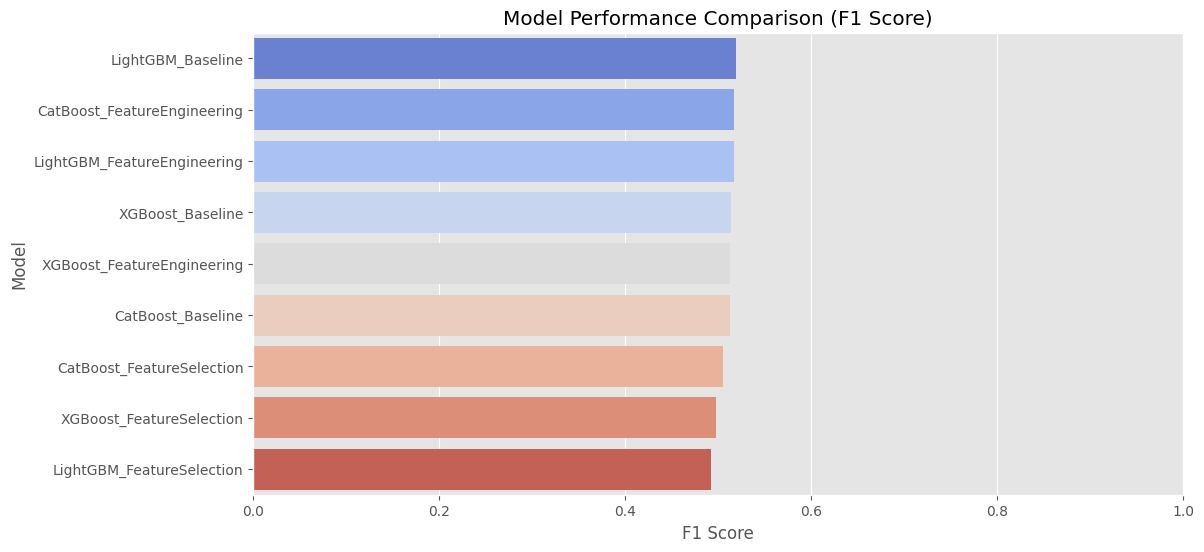


🏆 The best-performing model is **LightGBM_Baseline** with an F1 Score of **0.5190**.


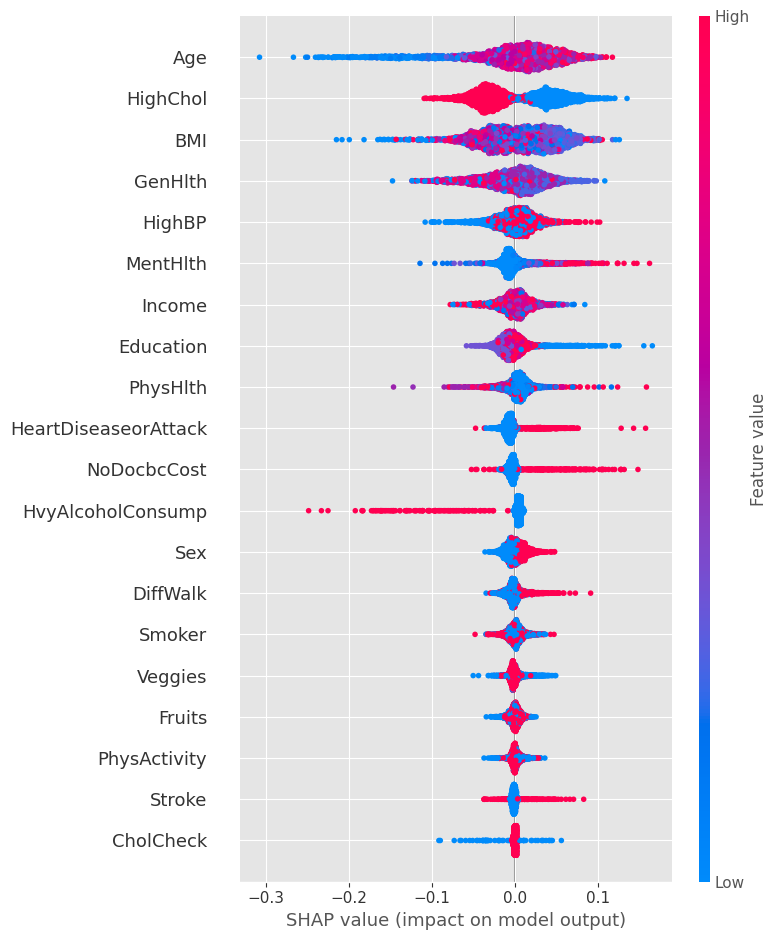

<ipython-input-5-54d767166eb1>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


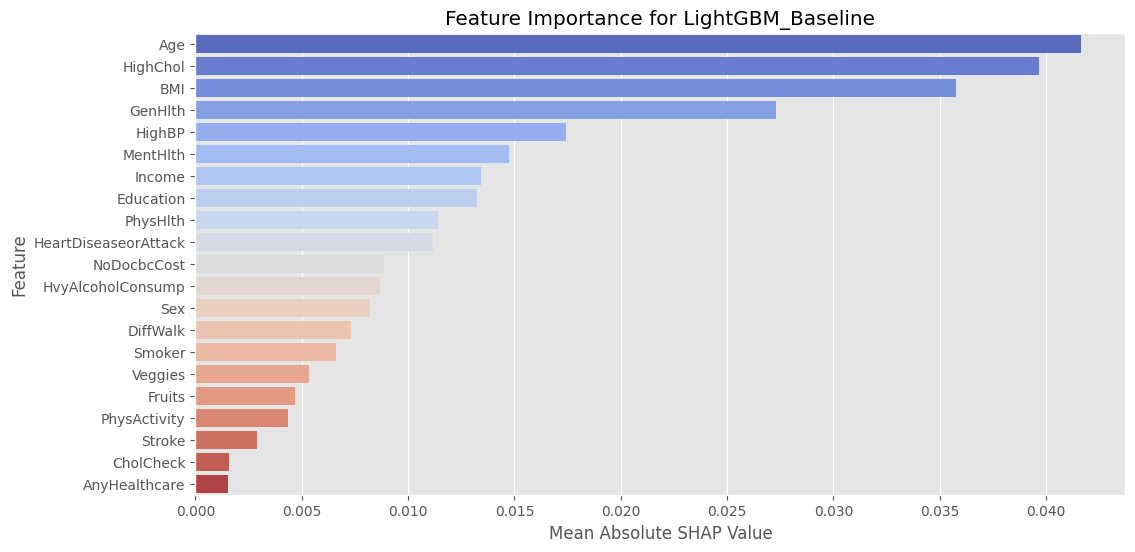

In [5]:
# Models Evaluation, Best Performer, SHAP Analysis

# Install SHAP for Explainability
!pip install --quiet shap

# Import necessary libraries
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Set Matplotlib style
plt.style.use("ggplot")

# ======== 📊 Model Performance Evaluation ========

# Store results in a dictionary
model_scores = {
    "XGBoost_Baseline": f1_score(y_test, y_pred_baseline_native, average='weighted'),
    "XGBoost_FeatureSelection": f1_score(y_test, y_pred_fs_native, average='weighted'),
    "XGBoost_FeatureEngineering": f1_score(y_test, y_pred_fe_native, average='weighted'),
    "LightGBM_Baseline": f1_score(y_test, lgb_baseline.predict(X_test_scaled), average='weighted'),
    "LightGBM_FeatureSelection": f1_score(y_test, lgb_fs.predict(X_test_fs), average='weighted'),
    "LightGBM_FeatureEngineering": f1_score(y_test, lgb_fe.predict(X_test_fe), average='weighted'),
    "CatBoost_Baseline": f1_score(y_test, cat_baseline.predict(X_test_scaled), average='weighted'),
    "CatBoost_FeatureSelection": f1_score(y_test, cat_fs.predict(X_test_fs), average='weighted'),
    "CatBoost_FeatureEngineering": f1_score(y_test, cat_fe.predict(X_test_fe), average='weighted')
}

# Convert to DataFrame for visualization
results_df = pd.DataFrame(model_scores.items(), columns=['Model', 'F1 Score'])
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# ======== 📊 Visualization: Model Comparison ========
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Model', data=results_df, palette="coolwarm")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.title("Model Performance Comparison (F1 Score)")
plt.xlim(0, 1)
plt.show()

# ======== 🏆 Selecting the Best Model ========
best_model = results_df.iloc[0]["Model"]
best_f1 = results_df.iloc[0]["F1 Score"]

print(f"\n🏆 The best-performing model is **{best_model}** with an F1 Score of **{best_f1:.4f}**.")

# ======== 🔍 SHAP Analysis ========

# Select the best model for SHAP analysis
if "XGBoost" in best_model:
    best_trained_model = xgb_baseline_native
    best_X_test = X_test_scaled
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(best_X_test)

elif "LightGBM" in best_model:
    best_trained_model = lgb_baseline
    best_X_test = X_test_scaled
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(best_X_test)

elif "CatBoost" in best_model:
    best_trained_model = cat_baseline
    best_X_test = X_test_scaled
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(best_X_test)

# ======== 🔍 Fixing SHAP Values Shape Issue ========
if isinstance(shap_values, list):
    # Convert list to NumPy array
    shap_values = np.array(shap_values)

    # Multi-class case: Extract SHAP values for the most confident predicted class
    predicted_class = np.argmax(best_trained_model.predict(best_X_test), axis=1)

    # Select SHAP values for the predicted class
    shap_values = shap_values[np.arange(len(predicted_class)), :, predicted_class]

# Ensure SHAP values are 2D before creating DataFrame
if shap_values.ndim == 3:
    shap_values = shap_values.mean(axis=2)  # Take mean across classes if still 3D

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# ======== 🔍 SHAP Feature Importance Plot ========
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, best_X_test, feature_names=X.columns)
plt.show()

# ======== 🔍 SHAP Feature Importance (Bar Chart) ========
shap_importance = np.abs(shap_df).mean(axis=0).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title(f"Feature Importance for {best_model}")
plt.show()


In [6]:
# Optimization Using Optuna

# Install necessary packages
!pip install --quiet xgboost lightgbm catboost scikit-learn numpy matplotlib pandas optuna

# Import required libraries
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score

# Set seed for reproducibility
SEED = 292001

# Load dataset
file_path = "diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

# Define target and features
target_col = "Diabetes_012"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Split dataset into training and testing sets (80% train, 20% test) WITHOUT stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Feature Selection
selector = SelectKBest(f_classif, k=10)
X_train_fs = selector.fit_transform(X_train_scaled, y_train)
X_test_fs = selector.transform(X_test_scaled)

# Apply Feature Engineering (Polynomial Features)
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_fe = poly.fit_transform(X_train_scaled)
X_test_fe = poly.transform(X_test_scaled)

# Function to optimize hyperparameters using Optuna
def optimize_model(trial, model_type, X_train, X_test, y_train, y_test):
    if model_type == "xgboost":
        params = {
            "objective": "multi:softmax",
            "num_class": len(y.unique()),
            "eval_metric": "mlogloss",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300)
        }
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        model = xgb.train(params, dtrain, num_boost_round=params["n_estimators"])
        y_pred = model.predict(dtest)

    elif model_type == "lightgbm":
        params = {
            "objective": "multiclass",
            "num_class": len(y.unique()),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
        }
        model = LGBMClassifier(**params, random_state=SEED)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    elif model_type == "catboost":
        print(f"Running Optuna for CatBoost...")  # Debugging print statement
        params = {
            "iterations": trial.suggest_int("iterations", 50, 300),
            "depth": trial.suggest_int("depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "border_count": trial.suggest_int("border_count", 32, 255),
        }
        model = CatBoostClassifier(**params, random_seed=SEED, verbose=100)  # Increased verbosity
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"CatBoost trial completed successfully.")  # Debugging statement

    return f1_score(y_test, y_pred, average="weighted")

# Function to run Optuna optimization for a given model type
def run_optimization(model_type, X_train, X_test, y_train, y_test):
    study = optuna.create_study(direction="maximize")
    try:
        study.optimize(
            lambda trial: optimize_model(trial, model_type, X_train, X_test, y_train, y_test),
            n_trials=20,
            catch=(Exception,)  # Ensures errors are caught and displayed
        )
    except Exception as e:
        print(f"Error optimizing {model_type}: {e}")  # Debugging print

    print(f"Best Params for {model_type}: {study.best_params}")  # Print before returning
    return study.best_params

# Store best parameters
best_params = {}

# Run optimization for each model and variant
print("\n🔍 Optimizing XGBoost Models...")
best_params["XGBoost_Baseline"] = run_optimization("xgboost", X_train_scaled, X_test_scaled, y_train, y_test)
best_params["XGBoost_FeatureSelection"] = run_optimization("xgboost", X_train_fs, X_test_fs, y_train, y_test)
best_params["XGBoost_FeatureEngineering"] = run_optimization("xgboost", X_train_fe, X_test_fe, y_train, y_test)

print("\n🔍 Optimizing LightGBM Models...")
best_params["LightGBM_Baseline"] = run_optimization("lightgbm", X_train_scaled, X_test_scaled, y_train, y_test)
best_params["LightGBM_FeatureSelection"] = run_optimization("lightgbm", X_train_fs, X_test_fs, y_train, y_test)
best_params["LightGBM_FeatureEngineering"] = run_optimization("lightgbm", X_train_fe, X_test_fe, y_train, y_test)

print("\n🔍 Optimizing CatBoost Models...")
best_params["CatBoost_Baseline"] = run_optimization("catboost", X_train_scaled, X_test_scaled, y_train, y_test)
best_params["CatBoost_FeatureSelection"] = run_optimization("catboost", X_train_fs, X_test_fs, y_train, y_test)
best_params["CatBoost_FeatureEngineering"] = run_optimization("catboost", X_train_fe, X_test_fe, y_train, y_test)

# Convert best parameters to DataFrame
best_params_df = pd.DataFrame(best_params).T

# Save to CSV (for reference)
best_params_df.to_csv("optuna_best_params.csv", index=True)

# Display the best parameters found
print("\n📌 Best Optimized Hyperparameters:")
print(best_params_df)  # Show full results


[I 2025-02-19 09:36:55,300] A new study created in memory with name: no-name-5e97cf00-1fc7-4fe5-b667-c0a2cb7900b0



🔍 Optimizing XGBoost Models...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 09:36:57,550] Trial 0 finished with value: 0.804961869734016 and parameters: {'learning_rate': 0.029301388477029015, 'max_depth': 3, 'subsample': 0.6881631196187173, 'colsample_bytree': 0.857672103797898, 'n_estimators': 197}. Best is trial 0 with value: 0.804961869734016.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 09:37:05,949] Trial 1 finished with value: 0.8136442613363416 and parameters: {'learning_rate': 0.056775897468121846, 'max_depth': 10, 'subsample': 0.9907838113802112, 'colsample_bytree': 0.6335497140275552, 'n_estimators': 247}. Best is trial 1 with value: 0.8136442613363416.
/usr/l

Best Params for xgboost: {'learning_rate': 0.26577032189763733, 'max_depth': 6, 'subsample': 0.7884362260651833, 'colsample_bytree': 0.7616830026507154, 'n_estimators': 171}


[I 2025-02-19 09:38:06,578] Trial 0 finished with value: 0.8104346811062699 and parameters: {'learning_rate': 0.1930401316648013, 'max_depth': 3, 'subsample': 0.7963850758118548, 'colsample_bytree': 0.8849336045648937, 'n_estimators': 240}. Best is trial 0 with value: 0.8104346811062699.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 09:38:08,654] Trial 1 finished with value: 0.8072312506410108 and parameters: {'learning_rate': 0.030646656253168644, 'max_depth': 3, 'subsample': 0.8042408621196679, 'colsample_bytree': 0.9174650328836238, 'n_estimators': 199}. Best is trial 0 with value: 0.8104346811062699.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 202

Best Params for xgboost: {'learning_rate': 0.29984869638548367, 'max_depth': 5, 'subsample': 0.9553637093199875, 'colsample_bytree': 0.6215572327461449, 'n_estimators': 77}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:39:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 09:39:14,952] Trial 0 finished with value: 0.8106951342226579 and parameters: {'learning_rate': 0.03075905498330881, 'max_depth': 10, 'subsample': 0.6154918729170245, 'colsample_bytree': 0.7203255553697893, 'n_estimators': 71}. Best is trial 0 with value: 0.8106951342226579.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:39:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-19 09:39:29,771] Trial 1 finished with value: 0.8127239631708074 and parameters: {'learning_rate': 0.048880413321962655, 'max_depth': 8, 'subsample': 0.9718632343025918, 'colsample_bytree': 0.7500533409223142, 'n_estimators': 133}. Best is trial 1 with value: 0.8127239631708074.
/usr/

Best Params for xgboost: {'learning_rate': 0.08888328018175382, 'max_depth': 7, 'subsample': 0.7594262223366117, 'colsample_bytree': 0.9435455477437674, 'n_estimators': 120}

🔍 Optimizing LightGBM Models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:20,032] Trial 0 finished with value: 0.8108696186281097 and parameters: {'learning_rate': 0.06710001697121341, 'max_depth': 10, 'n_estimators': 62, 'subsample': 0.6949424071858634, 'colsample_bytree': 0.8689712549498596}. Best is trial 0 with value: 0.8108696186281097.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:22,496] Trial 1 finished with value: 0.8122643173453966 and parameters: {'learning_rate': 0.062321995377606715, 'max_depth': 8, 'n_estimators': 166, 'subsample': 0.6398126414759815, 'colsample_bytree': 0.7293622946955807}. Best is trial 1 with value: 0.8122643173453966.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:24,117] Trial 2 finished with value: 0.7718423451085281 and parameters: {'learning_rate': 0.011509163467508311, 'max_depth': 9, 'n_estimators': 68, 'subsample': 0.9708571878932649, 'colsample_bytree': 0.9574603580121401}. Best is trial 1 with value: 0.8122643173453966.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:26,964] Trial 3 finished with value: 0.8100409987930975 and parameters: {'learning_rate': 0.032013462481110436, 'max_depth': 3, 'n_estimators': 229, 'subsample': 0.6455612735409726, 'colsample_bytree': 0.6529959119397725}. Best is trial 1 with value: 0.8122643173453966.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:30,332] Trial 4 finished with value: 0.8030765863166329 and parameters: {'learning_rate': 0.01274551106053678, 'max_depth': 9, 'n_estimators': 185, 'subsample': 0.6293348585964107, 'colsample_bytree': 0.918129873144261}. Best is trial 1 with value: 0.8122643173453966.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:31,642] Trial 5 finished with value: 0.8132946831801103 and parameters: {'learning_rate': 0.2431631315981316, 'max_depth': 8, 'n_estimators': 98, 'subsample': 0.9718960115594342, 'colsample_bytree': 0.9346593389879494}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:32,882] Trial 6 finished with value: 0.8106960546710529 and parameters: {'learning_rate': 0.067154686333313, 'max_depth': 7, 'n_estimators': 64, 'subsample': 0.6845268462156765, 'colsample_bytree': 0.9461310881237899}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:36,033] Trial 7 finished with value: 0.8129961060292547 and parameters: {'learning_rate': 0.18162777189227727, 'max_depth': 8, 'n_estimators': 262, 'subsample': 0.7886172663678624, 'colsample_bytree': 0.982263772375269}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:37,421] Trial 8 finished with value: 0.8124745240320689 and parameters: {'learning_rate': 0.10170803617116089, 'max_depth': 8, 'n_estimators': 64, 'subsample': 0.6799656921591192, 'colsample_bytree': 0.8655307839811568}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:38,489] Trial 9 finished with value: 0.8112555959450103 and parameters: {'learning_rate': 0.0930195340947222, 'max_depth': 4, 'n_estimators': 73, 'subsample': 0.9673881534020748, 'colsample_bytree': 0.9508009559286612}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:40,394] Trial 10 finished with value: 0.8129131859344744 and parameters: {'learning_rate': 0.19919561999553476, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.8821925159676965, 'colsample_bytree': 0.7673968880228478}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:44,150] Trial 11 finished with value: 0.8132140406276681 and parameters: {'learning_rate': 0.2926137428197601, 'max_depth': 6, 'n_estimators': 298, 'subsample': 0.7960228796915859, 'colsample_bytree': 0.8576760045500536}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:47,951] Trial 12 finished with value: 0.8127483500749666 and parameters: {'learning_rate': 0.2977024873998403, 'max_depth': 6, 'n_estimators': 283, 'subsample': 0.8020264534494999, 'colsample_bytree': 0.8381543970174441}. Best is trial 5 with value: 0.8132946831801103.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:49,703] Trial 13 finished with value: 0.8137181099854672 and parameters: {'learning_rate': 0.2931937772369201, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.8408556887333168, 'colsample_bytree': 0.8074968347063136}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:51,337] Trial 14 finished with value: 0.8137096647282658 and parameters: {'learning_rate': 0.1620653294863912, 'max_depth': 5, 'n_estimators': 106, 'subsample': 0.8929512546663306, 'colsample_bytree': 0.7163149760444573}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:53,259] Trial 15 finished with value: 0.8134391570522695 and parameters: {'learning_rate': 0.14996051287190582, 'max_depth': 5, 'n_estimators': 121, 'subsample': 0.8772645650008011, 'colsample_bytree': 0.6799448370108025}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:55,713] Trial 16 finished with value: 0.8083017144531512 and parameters: {'learning_rate': 0.031879076895998525, 'max_depth': 4, 'n_estimators': 158, 'subsample': 0.8873488293010937, 'colsample_bytree': 0.600995727083149}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:57,302] Trial 17 finished with value: 0.8134470270187284 and parameters: {'learning_rate': 0.1537591833558465, 'max_depth': 5, 'n_estimators': 105, 'subsample': 0.8365334435659991, 'colsample_bytree': 0.7842414102459113}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:43:59,805] Trial 18 finished with value: 0.8130938187104536 and parameters: {'learning_rate': 0.10962063840390761, 'max_depth': 3, 'n_estimators': 206, 'subsample': 0.9237698749690182, 'colsample_bytree': 0.733865304002397}. Best is trial 13 with value: 0.8137181099854672.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:02,307] Trial 19 finished with value: 0.8112618678038283 and parameters: {'learning_rate': 0.03884302603135007, 'max_depth': 7, 'n_estimators': 140, 'subsample': 0.7638277144395108, 'colsample_bytree': 0.8139783847451976}. Best is trial 13 with value: 0.8137181099854672.
[I 2025-02-19 09:44:02,309] A new study created in memory with name: no-name-ac26c113-ba70-4d97-98de-212827edf7e0
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Params for lightgbm: {'learning_rate': 0.2931937772369201, 'max_depth': 6, 'n_estimators': 123, 'subsample': 0.8408556887333168, 'colsample_bytree': 0.8074968347063136}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:03,835] Trial 0 finished with value: 0.8087749345427854 and parameters: {'learning_rate': 0.042225310295809095, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.821541912428505, 'colsample_bytree': 0.9573606563218142}. Best is trial 0 with value: 0.8087749345427854.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:04,995] Trial 1 finished with value: 0.8101836166695376 and parameters: {'learning_rate': 0.09782761063956928, 'max_depth': 7, 'n_estimators': 92, 'subsample': 0.96416115787667, 'colsample_bytree': 0.6685403345217932}. Best is trial 1 with value: 0.8101836166695376.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:06,618] Trial 2 finished with value: 0.8004268282317152 and parameters: {'learning_rate': 0.019114422183972274, 'max_depth': 9, 'n_estimators': 107, 'subsample': 0.8947592578390824, 'colsample_bytree': 0.7800329195420159}. Best is trial 1 with value: 0.8101836166695376.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:09,576] Trial 3 finished with value: 0.8098215111937537 and parameters: {'learning_rate': 0.10969051935676101, 'max_depth': 9, 'n_estimators': 286, 'subsample': 0.982446183163195, 'colsample_bytree': 0.7317700355326731}. Best is trial 1 with value: 0.8101836166695376.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:11,813] Trial 4 finished with value: 0.8103173950882542 and parameters: {'learning_rate': 0.16452032471468853, 'max_depth': 3, 'n_estimators': 225, 'subsample': 0.8974839324000901, 'colsample_bytree': 0.611820657597169}. Best is trial 4 with value: 0.8103173950882542.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:13,476] Trial 5 finished with value: 0.810159778650654 and parameters: {'learning_rate': 0.10966794462495087, 'max_depth': 8, 'n_estimators': 147, 'subsample': 0.9567219045477098, 'colsample_bytree': 0.9797906275482653}. Best is trial 4 with value: 0.8103173950882542.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:15,724] Trial 6 finished with value: 0.8097513462231049 and parameters: {'learning_rate': 0.06661560907935173, 'max_depth': 5, 'n_estimators': 202, 'subsample': 0.6064045030759844, 'colsample_bytree': 0.9427675934874928}. Best is trial 4 with value: 0.8103173950882542.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:17,721] Trial 7 finished with value: 0.8089708607801047 and parameters: {'learning_rate': 0.031462759937281204, 'max_depth': 5, 'n_estimators': 157, 'subsample': 0.6522906121602379, 'colsample_bytree': 0.6584598352886107}. Best is trial 4 with value: 0.8103173950882542.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:18,940] Trial 8 finished with value: 0.8091432366485051 and parameters: {'learning_rate': 0.04454343941248094, 'max_depth': 3, 'n_estimators': 141, 'subsample': 0.72976226823785, 'colsample_bytree': 0.8888862961175571}. Best is trial 4 with value: 0.8103173950882542.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:21,722] Trial 9 finished with value: 0.8103269259714854 and parameters: {'learning_rate': 0.08528429314213944, 'max_depth': 4, 'n_estimators': 298, 'subsample': 0.9123696346440965, 'colsample_bytree': 0.8388524601554657}. Best is trial 9 with value: 0.8103269259714854.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:25,074] Trial 10 finished with value: 0.8108395691862035 and parameters: {'learning_rate': 0.29660284063321835, 'max_depth': 4, 'n_estimators': 297, 'subsample': 0.8029973095320908, 'colsample_bytree': 0.8538665806413233}. Best is trial 10 with value: 0.8108395691862035.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:27,833] Trial 11 finished with value: 0.8103380260907762 and parameters: {'learning_rate': 0.2773365819229808, 'max_depth': 4, 'n_estimators': 299, 'subsample': 0.7909630510966412, 'colsample_bytree': 0.8476402908179758}. Best is trial 10 with value: 0.8108395691862035.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:30,432] Trial 12 finished with value: 0.810984386294386 and parameters: {'learning_rate': 0.2681823368961321, 'max_depth': 6, 'n_estimators': 254, 'subsample': 0.7943496071399798, 'colsample_bytree': 0.8545900365629473}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:32,919] Trial 13 finished with value: 0.8095270551607462 and parameters: {'learning_rate': 0.2905319827415302, 'max_depth': 6, 'n_estimators': 244, 'subsample': 0.7864900762774839, 'colsample_bytree': 0.8970137014665449}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:35,694] Trial 14 finished with value: 0.8101404753457108 and parameters: {'learning_rate': 0.19469603498830768, 'max_depth': 7, 'n_estimators': 255, 'subsample': 0.7204249380453853, 'colsample_bytree': 0.7770343824650929}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:36,634] Trial 15 finished with value: 0.8108306927950489 and parameters: {'learning_rate': 0.1724388424903349, 'max_depth': 6, 'n_estimators': 56, 'subsample': 0.8377765169231346, 'colsample_bytree': 0.8293170504118794}. Best is trial 12 with value: 0.810984386294386.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:40,348] Trial 16 finished with value: 0.8086641188634344 and parameters: {'learning_rate': 0.015053284407637597, 'max_depth': 10, 'n_estimators': 265, 'subsample': 0.7371998886680312, 'colsample_bytree': 0.8911055583217803}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:42,154] Trial 17 finished with value: 0.8105525130056499 and parameters: {'learning_rate': 0.20864789513933166, 'max_depth': 4, 'n_estimators': 195, 'subsample': 0.8547863205162491, 'colsample_bytree': 0.7580681306070045}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:44,530] Trial 18 finished with value: 0.8094774251170186 and parameters: {'learning_rate': 0.14426131161395414, 'max_depth': 6, 'n_estimators': 225, 'subsample': 0.6837370505902385, 'colsample_bytree': 0.9203022716092804}. Best is trial 12 with value: 0.810984386294386.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:44:47,181] Trial 19 finished with value: 0.8101797946918035 and parameters: {'learning_rate': 0.29917733579810957, 'max_depth': 8, 'n_estimators': 271, 'subsample': 0.7759808511684692, 'colsample_bytree': 0.7152396635715103}. Best is trial 12 with value: 0.810984386294386.
[I 2025-02-19 09:44:47,183] A new study created in memory with name: no-name-d07f58d4-288d-4159-b71f-8a734bfb0880
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best Params for lightgbm: {'learning_rate': 0.2681823368961321, 'max_depth': 6, 'n_estimators': 254, 'subsample': 0.7943496071399798, 'colsample_bytree': 0.8545900365629473}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:45:06,420] Trial 0 finished with value: 0.8143253870936771 and parameters: {'learning_rate': 0.12950083255370465, 'max_depth': 8, 'n_estimators': 272, 'subsample': 0.8433650465847674, 'colsample_bytree': 0.6041310294406464}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:45:21,291] Trial 1 finished with value: 0.8117802389430215 and parameters: {'learning_rate': 0.03478884671099126, 'max_depth': 5, 'n_estimators': 161, 'subsample': 0.9383790215950765, 'colsample_bytree': 0.6739602235687827}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:45:31,412] Trial 2 finished with value: 0.8120810006965867 and parameters: {'learning_rate': 0.055594335615908624, 'max_depth': 9, 'n_estimators': 85, 'subsample': 0.6399791693526597, 'colsample_bytree': 0.8720087827811023}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:45:49,799] Trial 3 finished with value: 0.8107225977631974 and parameters: {'learning_rate': 0.027657953173027272, 'max_depth': 4, 'n_estimators': 217, 'subsample': 0.9132018651195336, 'colsample_bytree': 0.782286643553517}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:46:13,536] Trial 4 finished with value: 0.8086943718966272 and parameters: {'learning_rate': 0.015065922283021947, 'max_depth': 9, 'n_estimators': 201, 'subsample': 0.839792807750706, 'colsample_bytree': 0.8446495539576163}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:46:35,155] Trial 5 finished with value: 0.8111721688400835 and parameters: {'learning_rate': 0.018722870163889623, 'max_depth': 7, 'n_estimators': 212, 'subsample': 0.7051598408177654, 'colsample_bytree': 0.6638740588533275}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:46:51,543] Trial 6 finished with value: 0.8128507052404107 and parameters: {'learning_rate': 0.041976783876745555, 'max_depth': 8, 'n_estimators': 183, 'subsample': 0.7916734062150681, 'colsample_bytree': 0.6545672077735137}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:47:07,133] Trial 7 finished with value: 0.8106318474575535 and parameters: {'learning_rate': 0.02684978088622984, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.6349311221845698, 'colsample_bytree': 0.6448225675636273}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:47:17,653] Trial 8 finished with value: 0.8053009440989026 and parameters: {'learning_rate': 0.027539839820423205, 'max_depth': 3, 'n_estimators': 128, 'subsample': 0.9207313185207461, 'colsample_bytree': 0.7797911855819553}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:47:25,913] Trial 9 finished with value: 0.7986428910666767 and parameters: {'learning_rate': 0.030104328418487772, 'max_depth': 9, 'n_estimators': 54, 'subsample': 0.818605702388519, 'colsample_bytree': 0.8851305575635462}. Best is trial 0 with value: 0.8143253870936771.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:47:46,604] Trial 10 finished with value: 0.8144193354493543 and parameters: {'learning_rate': 0.1772654606299718, 'max_depth': 10, 'n_estimators': 296, 'subsample': 0.9916666455440256, 'colsample_bytree': 0.980934178133232}. Best is trial 10 with value: 0.8144193354493543.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:48:07,766] Trial 11 finished with value: 0.8138158771904312 and parameters: {'learning_rate': 0.1725762573538691, 'max_depth': 10, 'n_estimators': 294, 'subsample': 0.9955551931469138, 'colsample_bytree': 0.9678129897463565}. Best is trial 10 with value: 0.8144193354493543.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:48:29,032] Trial 12 finished with value: 0.8147891830153429 and parameters: {'learning_rate': 0.19429109887353127, 'max_depth': 10, 'n_estimators': 299, 'subsample': 0.729810271122385, 'colsample_bytree': 0.997969493564675}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:48:46,917] Trial 13 finished with value: 0.8125503306355627 and parameters: {'learning_rate': 0.2870342935739617, 'max_depth': 10, 'n_estimators': 257, 'subsample': 0.7482653777461854, 'colsample_bytree': 0.9897130844568548}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:49:07,187] Trial 14 finished with value: 0.8142197057995406 and parameters: {'learning_rate': 0.09552306246376416, 'max_depth': 10, 'n_estimators': 252, 'subsample': 0.7017458189604372, 'colsample_bytree': 0.9252079276604016}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:49:28,064] Trial 15 finished with value: 0.813197752136239 and parameters: {'learning_rate': 0.29920101954036177, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7546317956498455, 'colsample_bytree': 0.9498438261047709}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:49:45,714] Trial 16 finished with value: 0.8141684764032627 and parameters: {'learning_rate': 0.17834517352486517, 'max_depth': 8, 'n_estimators': 248, 'subsample': 0.9904033231333498, 'colsample_bytree': 0.9922136442495567}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:50:04,049] Trial 17 finished with value: 0.8139633746308603 and parameters: {'learning_rate': 0.08668845572747058, 'max_depth': 10, 'n_estimators': 228, 'subsample': 0.8771044155384139, 'colsample_bytree': 0.9224576315753368}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:50:26,141] Trial 18 finished with value: 0.814175074236712 and parameters: {'learning_rate': 0.06885933076069929, 'max_depth': 6, 'n_estimators': 288, 'subsample': 0.7030954029797379, 'colsample_bytree': 0.7248986325530989}. Best is trial 12 with value: 0.8147891830153429.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-19 09:50:57,475] Trial 19 finished with value: 0.806793627303042 and parameters: {'learning_rate': 0.010056340939581304, 'max_depth': 9, 'n_estimators': 270, 'subsample': 0.7816282768928129, 'colsample_bytree': 0.8309377403397311}. Best is trial 12 with value: 0.8147891830153429.
[I 2025-02-19 09:50:57,477] A new study created in memory with name: no-name-903a8890-652f-4106-b14d-ea852c3b6d5c


Best Params for lightgbm: {'learning_rate': 0.19429109887353127, 'max_depth': 10, 'n_estimators': 299, 'subsample': 0.729810271122385, 'colsample_bytree': 0.997969493564675}

🔍 Optimizing CatBoost Models...
Running Optuna for CatBoost...
0:	learn: 0.8790407	total: 21.4ms	remaining: 2.5s
100:	learn: 0.3882591	total: 1.76s	remaining: 296ms


[I 2025-02-19 09:50:59,677] Trial 0 finished with value: 0.8133695642442532 and parameters: {'iterations': 118, 'depth': 5, 'learning_rate': 0.18717955246994716, 'l2_leaf_reg': 5.045953340295195, 'border_count': 66}. Best is trial 0 with value: 0.8133695642442532.


117:	learn: 0.3876615	total: 2.01s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0818149	total: 20.9ms	remaining: 1.96s


[I 2025-02-19 09:51:01,596] Trial 1 finished with value: 0.799300715670132 and parameters: {'iterations': 95, 'depth': 6, 'learning_rate': 0.013004698267283921, 'l2_leaf_reg': 3.976533125915916, 'border_count': 210}. Best is trial 0 with value: 0.8133695642442532.


94:	learn: 0.5105612	total: 1.74s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0546356	total: 81.6ms	remaining: 24.1s
100:	learn: 0.3942339	total: 7.34s	remaining: 14.2s
200:	learn: 0.3793087	total: 14.9s	remaining: 7.04s


[I 2025-02-19 09:51:23,892] Trial 2 finished with value: 0.8128066062433346 and parameters: {'iterations': 296, 'depth': 10, 'learning_rate': 0.03418248719540355, 'l2_leaf_reg': 2.876085437575459, 'border_count': 106}. Best is trial 0 with value: 0.8133695642442532.


295:	learn: 0.3714804	total: 22.1s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0702144	total: 16.4ms	remaining: 4.87s
100:	learn: 0.4287386	total: 1.61s	remaining: 3.15s
200:	learn: 0.3971312	total: 3.17s	remaining: 1.53s


[I 2025-02-19 09:51:28,747] Trial 3 finished with value: 0.8108802298312483 and parameters: {'iterations': 298, 'depth': 5, 'learning_rate': 0.02211057215391568, 'l2_leaf_reg': 8.529849863402335, 'border_count': 135}. Best is trial 0 with value: 0.8133695642442532.


297:	learn: 0.3931455	total: 4.65s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9234930	total: 13ms	remaining: 803ms


[I 2025-02-19 09:51:29,706] Trial 4 finished with value: 0.8122280551906264 and parameters: {'iterations': 63, 'depth': 3, 'learning_rate': 0.14906949390297974, 'l2_leaf_reg': 4.593344154954288, 'border_count': 132}. Best is trial 0 with value: 0.8133695642442532.


62:	learn: 0.3942130	total: 798ms	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0828322	total: 37.9ms	remaining: 10.4s
100:	learn: 0.5103555	total: 3.81s	remaining: 6.61s
200:	learn: 0.4175279	total: 7.63s	remaining: 2.85s


[I 2025-02-19 09:51:40,360] Trial 5 finished with value: 0.8071171680906006 and parameters: {'iterations': 276, 'depth': 8, 'learning_rate': 0.012165388288745442, 'l2_leaf_reg': 5.021102727516534, 'border_count': 241}. Best is trial 0 with value: 0.8133695642442532.


275:	learn: 0.3997608	total: 10.5s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8802375	total: 14.1ms	remaining: 2.65s
100:	learn: 0.3901453	total: 1.38s	remaining: 1.22s


[I 2025-02-19 09:51:43,103] Trial 6 finished with value: 0.8134408776485288 and parameters: {'iterations': 190, 'depth': 4, 'learning_rate': 0.18858712934022612, 'l2_leaf_reg': 5.166098072821289, 'border_count': 117}. Best is trial 6 with value: 0.8134408776485288.


189:	learn: 0.3882078	total: 2.56s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7799852	total: 74.9ms	remaining: 10.8s
100:	learn: 0.3235845	total: 7.64s	remaining: 3.33s


[I 2025-02-19 09:51:54,254] Trial 7 finished with value: 0.8126334840362229 and parameters: {'iterations': 145, 'depth': 10, 'learning_rate': 0.28510724173557356, 'l2_leaf_reg': 1.1355690636918947, 'border_count': 160}. Best is trial 6 with value: 0.8134408776485288.


144:	learn: 0.2970272	total: 11s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0592491	total: 76.7ms	remaining: 19.9s
100:	learn: 0.4007081	total: 7.5s	remaining: 11.8s
200:	learn: 0.3838159	total: 15s	remaining: 4.4s


[I 2025-02-19 09:52:13,908] Trial 8 finished with value: 0.8122969409620341 and parameters: {'iterations': 260, 'depth': 10, 'learning_rate': 0.03081829798871643, 'l2_leaf_reg': 7.0711382799411435, 'border_count': 74}. Best is trial 6 with value: 0.8134408776485288.


259:	learn: 0.3800519	total: 19.4s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0544092	total: 38.2ms	remaining: 4.01s
100:	learn: 0.3987593	total: 3.81s	remaining: 189ms
105:	learn: 0.3972452	total: 4s	remaining: 0us


[I 2025-02-19 09:52:18,083] Trial 9 finished with value: 0.8079425459342032 and parameters: {'iterations': 106, 'depth': 8, 'learning_rate': 0.0345668168685686, 'l2_leaf_reg': 7.533142560636148, 'border_count': 246}. Best is trial 6 with value: 0.8134408776485288.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9930854	total: 12.7ms	remaining: 2.67s
100:	learn: 0.3944807	total: 1.29s	remaining: 1.41s


[I 2025-02-19 09:52:21,141] Trial 10 finished with value: 0.8129952292732078 and parameters: {'iterations': 211, 'depth': 3, 'learning_rate': 0.08679453603004858, 'l2_leaf_reg': 9.995596601656928, 'border_count': 177}. Best is trial 6 with value: 0.8134408776485288.


200:	learn: 0.3918601	total: 2.71s	remaining: 135ms
210:	learn: 0.3917236	total: 2.85s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7759522	total: 18.2ms	remaining: 3.33s
100:	learn: 0.3863276	total: 1.58s	remaining: 1.3s


[I 2025-02-19 09:52:24,185] Trial 11 finished with value: 0.8133275079829485 and parameters: {'iterations': 184, 'depth': 5, 'learning_rate': 0.29279448112475986, 'l2_leaf_reg': 5.996078869366961, 'border_count': 38}. Best is trial 6 with value: 0.8134408776485288.


183:	learn: 0.3827081	total: 2.84s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9427626	total: 14.4ms	remaining: 2.07s
100:	learn: 0.3909648	total: 1.41s	remaining: 613ms


[I 2025-02-19 09:52:26,383] Trial 12 finished with value: 0.8140994102061608 and parameters: {'iterations': 145, 'depth': 4, 'learning_rate': 0.13004332025572962, 'l2_leaf_reg': 2.8782544979144857, 'border_count': 80}. Best is trial 12 with value: 0.8140994102061608.


144:	learn: 0.3898160	total: 2s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9940304	total: 14.8ms	remaining: 3.19s
100:	learn: 0.3927323	total: 1.42s	remaining: 1.63s
200:	learn: 0.3902451	total: 2.77s	remaining: 221ms


[I 2025-02-19 09:52:29,565] Trial 13 finished with value: 0.8138466244732712 and parameters: {'iterations': 217, 'depth': 4, 'learning_rate': 0.08511311008534714, 'l2_leaf_reg': 2.5967817995125024, 'border_count': 99}. Best is trial 12 with value: 0.8140994102061608.


216:	learn: 0.3900053	total: 2.98s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0072113	total: 14.2ms	remaining: 3.2s
100:	learn: 0.3936503	total: 1.42s	remaining: 1.77s
200:	learn: 0.3906763	total: 2.93s	remaining: 379ms


[I 2025-02-19 09:52:33,101] Trial 14 finished with value: 0.8136601687369526 and parameters: {'iterations': 227, 'depth': 4, 'learning_rate': 0.07393257392317164, 'l2_leaf_reg': 2.1920566079501675, 'border_count': 89}. Best is trial 12 with value: 0.8140994102061608.


226:	learn: 0.3903018	total: 3.32s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9657787	total: 25.2ms	remaining: 3.81s
100:	learn: 0.3860061	total: 2.16s	remaining: 1.09s


[I 2025-02-19 09:52:36,541] Trial 15 finished with value: 0.8131079361025669 and parameters: {'iterations': 152, 'depth': 7, 'learning_rate': 0.10764037828602602, 'l2_leaf_reg': 3.276672860341419, 'border_count': 61}. Best is trial 12 with value: 0.8140994102061608.


151:	learn: 0.3822307	total: 3.23s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0357938	total: 14.3ms	remaining: 3.11s
100:	learn: 0.3969551	total: 1.43s	remaining: 1.67s
200:	learn: 0.3922174	total: 2.79s	remaining: 250ms


[I 2025-02-19 09:52:39,776] Trial 16 finished with value: 0.8126868208659295 and parameters: {'iterations': 219, 'depth': 4, 'learning_rate': 0.04980832388546341, 'l2_leaf_reg': 1.1824644849668213, 'border_count': 33}. Best is trial 12 with value: 0.8140994102061608.


218:	learn: 0.3918516	total: 3.03s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9438277	total: 19.7ms	remaining: 2.96s
100:	learn: 0.3876226	total: 1.78s	remaining: 883ms


[I 2025-02-19 09:52:42,626] Trial 17 finished with value: 0.8130046385687208 and parameters: {'iterations': 151, 'depth': 6, 'learning_rate': 0.12723961774380102, 'l2_leaf_reg': 2.423249182919732, 'border_count': 97}. Best is trial 12 with value: 0.8140994102061608.


150:	learn: 0.3849214	total: 2.65s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0243891	total: 12.9ms	remaining: 3.07s
100:	learn: 0.3971509	total: 1.39s	remaining: 1.9s
200:	learn: 0.3932070	total: 2.81s	remaining: 531ms


[I 2025-02-19 09:52:46,104] Trial 18 finished with value: 0.8130537376000786 and parameters: {'iterations': 239, 'depth': 3, 'learning_rate': 0.06014671268235824, 'l2_leaf_reg': 3.74491495154726, 'border_count': 179}. Best is trial 12 with value: 0.8140994102061608.


238:	learn: 0.3925740	total: 3.27s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9872386	total: 21.3ms	remaining: 1.28s


[I 2025-02-19 09:52:47,598] Trial 19 finished with value: 0.8104210445870685 and parameters: {'iterations': 61, 'depth': 7, 'learning_rate': 0.0890776141353778, 'l2_leaf_reg': 2.024886371566597, 'border_count': 79}. Best is trial 12 with value: 0.8140994102061608.
[I 2025-02-19 09:52:47,600] A new study created in memory with name: no-name-75d14be8-5725-4ec5-897e-14a7a9cdfaf9


60:	learn: 0.3914943	total: 1.31s	remaining: 0us
CatBoost trial completed successfully.
Best Params for catboost: {'iterations': 145, 'depth': 4, 'learning_rate': 0.13004332025572962, 'l2_leaf_reg': 2.8782544979144857, 'border_count': 80}
Running Optuna for CatBoost...
0:	learn: 0.9224316	total: 17.8ms	remaining: 4.31s
100:	learn: 0.3824354	total: 4.15s	remaining: 5.84s
200:	learn: 0.3737790	total: 8.25s	remaining: 1.72s


[I 2025-02-19 09:52:57,869] Trial 0 finished with value: 0.8105114355903436 and parameters: {'iterations': 243, 'depth': 9, 'learning_rate': 0.14971244301727898, 'l2_leaf_reg': 8.428019871573346, 'border_count': 181}. Best is trial 0 with value: 0.8105114355903436.


242:	learn: 0.3702980	total: 10.1s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0167602	total: 14.2ms	remaining: 2.73s
100:	learn: 0.3960329	total: 1.38s	remaining: 1.27s


[I 2025-02-19 09:53:00,668] Trial 1 finished with value: 0.8105863280965497 and parameters: {'iterations': 194, 'depth': 4, 'learning_rate': 0.06640028985652903, 'l2_leaf_reg': 6.246655895924798, 'border_count': 149}. Best is trial 1 with value: 0.8105863280965497.


193:	learn: 0.3940510	total: 2.63s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0776297	total: 17.8ms	remaining: 1.64s


[I 2025-02-19 09:53:05,516] Trial 2 finished with value: 0.8035324878839463 and parameters: {'iterations': 93, 'depth': 10, 'learning_rate': 0.016587233663719187, 'l2_leaf_reg': 7.048747269101065, 'border_count': 62}. Best is trial 1 with value: 0.8105863280965497.


92:	learn: 0.4713498	total: 4.69s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0241507	total: 13.6ms	remaining: 2.27s
100:	learn: 0.3954734	total: 1.52s	remaining: 1.01s


[I 2025-02-19 09:53:08,271] Trial 3 finished with value: 0.8103061614362412 and parameters: {'iterations': 168, 'depth': 5, 'learning_rate': 0.060205510562025714, 'l2_leaf_reg': 6.131294943923576, 'border_count': 211}. Best is trial 1 with value: 0.8105863280965497.


167:	learn: 0.3935059	total: 2.59s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8797095	total: 19.7ms	remaining: 5.31s
100:	learn: 0.3714521	total: 5.46s	remaining: 9.14s
200:	learn: 0.3546111	total: 11s	remaining: 3.76s


[I 2025-02-19 09:53:23,294] Trial 4 finished with value: 0.8106014066210531 and parameters: {'iterations': 270, 'depth': 10, 'learning_rate': 0.19045151096739585, 'l2_leaf_reg': 5.573694055671144, 'border_count': 249}. Best is trial 4 with value: 0.8106014066210531.


269:	learn: 0.3445070	total: 14.8s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0714219	total: 12.9ms	remaining: 3.17s
100:	learn: 0.4362382	total: 1.28s	remaining: 1.85s
200:	learn: 0.4019547	total: 2.53s	remaining: 580ms


[I 2025-02-19 09:53:26,576] Trial 5 finished with value: 0.8063587642862041 and parameters: {'iterations': 247, 'depth': 3, 'learning_rate': 0.021544323642379036, 'l2_leaf_reg': 5.110252938630571, 'border_count': 107}. Best is trial 4 with value: 0.8106014066210531.


246:	learn: 0.3992938	total: 3.11s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8410251	total: 13.3ms	remaining: 1.48s


[I 2025-02-19 09:53:28,217] Trial 6 finished with value: 0.8110220037191007 and parameters: {'iterations': 112, 'depth': 4, 'learning_rate': 0.22938758309167215, 'l2_leaf_reg': 2.6823618214628366, 'border_count': 237}. Best is trial 6 with value: 0.8110220037191007.


100:	learn: 0.3928899	total: 1.34s	remaining: 146ms
111:	learn: 0.3926719	total: 1.49s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8249565	total: 18.2ms	remaining: 3.94s
100:	learn: 0.3754340	total: 4.26s	remaining: 4.93s
200:	learn: 0.3604094	total: 8.36s	remaining: 707ms


[I 2025-02-19 09:53:37,483] Trial 7 finished with value: 0.8107076897143268 and parameters: {'iterations': 218, 'depth': 9, 'learning_rate': 0.24636129727494704, 'l2_leaf_reg': 6.447859497126047, 'border_count': 230}. Best is trial 6 with value: 0.8110220037191007.


217:	learn: 0.3584957	total: 9.08s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8217669	total: 13.5ms	remaining: 4.01s
100:	learn: 0.3926125	total: 1.33s	remaining: 2.59s
200:	learn: 0.3908176	total: 2.62s	remaining: 1.26s


[I 2025-02-19 09:53:41,553] Trial 8 finished with value: 0.8100856204246732 and parameters: {'iterations': 298, 'depth': 4, 'learning_rate': 0.2496223395264029, 'l2_leaf_reg': 1.5645290287943445, 'border_count': 217}. Best is trial 6 with value: 0.8110220037191007.


297:	learn: 0.3894960	total: 3.89s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9061566	total: 13.3ms	remaining: 3.42s
100:	learn: 0.3905638	total: 1.73s	remaining: 2.67s
200:	learn: 0.3873174	total: 3.44s	remaining: 957ms


[I 2025-02-19 09:53:46,061] Trial 9 finished with value: 0.8105385199340579 and parameters: {'iterations': 257, 'depth': 6, 'learning_rate': 0.16493717871895544, 'l2_leaf_reg': 5.2670762217166915, 'border_count': 209}. Best is trial 6 with value: 0.8110220037191007.


256:	learn: 0.3856951	total: 4.33s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0557208	total: 14.1ms	remaining: 706ms


[I 2025-02-19 09:53:47,211] Trial 10 finished with value: 0.8019706219680532 and parameters: {'iterations': 51, 'depth': 7, 'learning_rate': 0.03419567440764415, 'l2_leaf_reg': 2.237121327088617, 'border_count': 122}. Best is trial 6 with value: 0.8110220037191007.


50:	learn: 0.4527985	total: 991ms	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9757090	total: 18ms	remaining: 2.59s
100:	learn: 0.3877099	total: 3.35s	remaining: 1.46s


[I 2025-02-19 09:53:52,221] Trial 11 finished with value: 0.8105638329270922 and parameters: {'iterations': 145, 'depth': 8, 'learning_rate': 0.10159398960165876, 'l2_leaf_reg': 3.59622706673282, 'border_count': 253}. Best is trial 6 with value: 0.8110220037191007.


144:	learn: 0.3845495	total: 4.83s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7945502	total: 13.3ms	remaining: 1.52s
100:	learn: 0.3856893	total: 1.84s	remaining: 256ms


[I 2025-02-19 09:53:54,494] Trial 12 finished with value: 0.8111013194784339 and parameters: {'iterations': 115, 'depth': 7, 'learning_rate': 0.27961433977479366, 'l2_leaf_reg': 9.409065979049046, 'border_count': 174}. Best is trial 12 with value: 0.8111013194784339.


114:	learn: 0.3847370	total: 2.1s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9740475	total: 14.9ms	remaining: 1.79s
100:	learn: 0.3923400	total: 1.87s	remaining: 370ms


[I 2025-02-19 09:53:56,868] Trial 13 finished with value: 0.8097507184562518 and parameters: {'iterations': 121, 'depth': 6, 'learning_rate': 0.10312466070296225, 'l2_leaf_reg': 9.954200655145456, 'border_count': 174}. Best is trial 12 with value: 0.8111013194784339.


120:	learn: 0.3916936	total: 2.2s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0850268	total: 14.1ms	remaining: 1.34s


[I 2025-02-19 09:53:58,912] Trial 14 finished with value: 0.8012598120060332 and parameters: {'iterations': 96, 'depth': 7, 'learning_rate': 0.01070358889886297, 'l2_leaf_reg': 3.640647895583866, 'border_count': 179}. Best is trial 12 with value: 0.8111013194784339.


95:	learn: 0.5459670	total: 1.87s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7771243	total: 14.1ms	remaining: 749ms


[I 2025-02-19 09:53:59,879] Trial 15 finished with value: 0.8102416028916256 and parameters: {'iterations': 54, 'depth': 5, 'learning_rate': 0.2955482445857513, 'l2_leaf_reg': 9.811092073732617, 'border_count': 47}. Best is trial 12 with value: 0.8111013194784339.


53:	learn: 0.3925822	total: 792ms	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9653712	total: 13.7ms	remaining: 1.82s
100:	learn: 0.3932633	total: 1.5s	remaining: 489ms


[I 2025-02-19 09:54:02,070] Trial 16 finished with value: 0.8106770751502542 and parameters: {'iterations': 134, 'depth': 5, 'learning_rate': 0.11069558722161668, 'l2_leaf_reg': 3.577457296561451, 'border_count': 87}. Best is trial 12 with value: 0.8111013194784339.


133:	learn: 0.3924318	total: 2.01s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0477285	total: 12.7ms	remaining: 1.17s


[I 2025-02-19 09:54:03,421] Trial 17 finished with value: 0.8013552664379776 and parameters: {'iterations': 93, 'depth': 3, 'learning_rate': 0.040733808060546786, 'l2_leaf_reg': 8.482597873578879, 'border_count': 149}. Best is trial 12 with value: 0.8111013194784339.


92:	learn: 0.4046912	total: 1.19s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8921676	total: 17.9ms	remaining: 2.97s
100:	learn: 0.3824302	total: 3.39s	remaining: 2.22s


[I 2025-02-19 09:54:09,308] Trial 18 finished with value: 0.8110440557670877 and parameters: {'iterations': 167, 'depth': 8, 'learning_rate': 0.1782629938700637, 'l2_leaf_reg': 2.473254179422991, 'border_count': 189}. Best is trial 12 with value: 0.8111013194784339.


166:	learn: 0.3756159	total: 5.69s	remaining: 0us
CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0003627	total: 18.9ms	remaining: 3.44s
100:	learn: 0.3882633	total: 3.31s	remaining: 2.69s


[I 2025-02-19 09:54:15,556] Trial 19 finished with value: 0.8104104113780349 and parameters: {'iterations': 183, 'depth': 8, 'learning_rate': 0.08025283068677362, 'l2_leaf_reg': 1.1873638106567004, 'border_count': 193}. Best is trial 12 with value: 0.8111013194784339.
[I 2025-02-19 09:54:15,557] A new study created in memory with name: no-name-59c53aeb-41d0-46f7-be69-62f77ad83cf6


182:	learn: 0.3827328	total: 6.06s	remaining: 0us
CatBoost trial completed successfully.
Best Params for catboost: {'iterations': 115, 'depth': 7, 'learning_rate': 0.27961433977479366, 'l2_leaf_reg': 9.409065979049046, 'border_count': 174}
Running Optuna for CatBoost...
0:	learn: 0.9693564	total: 122ms	remaining: 33.7s
100:	learn: 0.3854617	total: 10.1s	remaining: 17.4s
200:	learn: 0.3777620	total: 18.6s	remaining: 6.95s
275:	learn: 0.3727358	total: 24.8s	remaining: 0us


[I 2025-02-19 09:54:57,035] Trial 0 finished with value: 0.8127323418591844 and parameters: {'iterations': 276, 'depth': 7, 'learning_rate': 0.1045601464931731, 'l2_leaf_reg': 1.4473716779140149, 'border_count': 243}. Best is trial 0 with value: 0.8127323418591844.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9712163	total: 369ms	remaining: 50.1s
100:	learn: 0.3834552	total: 37.7s	remaining: 13.4s
136:	learn: 0.3797656	total: 51.1s	remaining: 0us


[I 2025-02-19 09:56:04,828] Trial 1 finished with value: 0.8135451839387987 and parameters: {'iterations': 137, 'depth': 8, 'learning_rate': 0.10388696810292758, 'l2_leaf_reg': 6.427406317608125, 'border_count': 38}. Best is trial 1 with value: 0.8135451839387987.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0615384	total: 66.8ms	remaining: 16.4s
100:	learn: 0.4151130	total: 6.35s	remaining: 9.18s
200:	learn: 0.3982595	total: 11.9s	remaining: 2.72s
246:	learn: 0.3964231	total: 14.6s	remaining: 0us


[I 2025-02-19 09:56:36,951] Trial 2 finished with value: 0.8099448504669404 and parameters: {'iterations': 247, 'depth': 3, 'learning_rate': 0.029189734634490937, 'l2_leaf_reg': 4.9853507505704755, 'border_count': 221}. Best is trial 1 with value: 0.8135451839387987.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0729443	total: 102ms	remaining: 21.7s
100:	learn: 0.4383603	total: 9.91s	remaining: 11.2s
200:	learn: 0.3980089	total: 19s	remaining: 1.32s
214:	learn: 0.3966243	total: 20.2s	remaining: 0us


[I 2025-02-19 09:57:14,294] Trial 3 finished with value: 0.8090787754034169 and parameters: {'iterations': 215, 'depth': 6, 'learning_rate': 0.01987556525919366, 'l2_leaf_reg': 1.0198812320914064, 'border_count': 200}. Best is trial 1 with value: 0.8135451839387987.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9950241	total: 436ms	remaining: 2m 8s
100:	learn: 0.3806498	total: 44.3s	remaining: 1m 25s
200:	learn: 0.3679781	total: 1m 28s	remaining: 41.6s
295:	learn: 0.3571840	total: 2m 9s	remaining: 0us


[I 2025-02-19 09:59:40,963] Trial 4 finished with value: 0.8136478587612407 and parameters: {'iterations': 296, 'depth': 9, 'learning_rate': 0.08311336290374045, 'l2_leaf_reg': 3.2700517725863043, 'border_count': 112}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0514844	total: 372ms	remaining: 1m 27s
100:	learn: 0.3974975	total: 38.1s	remaining: 51s
200:	learn: 0.3878493	total: 1m 15s	remaining: 13.2s
235:	learn: 0.3863008	total: 1m 29s	remaining: 0us


[I 2025-02-19 10:01:27,443] Trial 5 finished with value: 0.812816312996889 and parameters: {'iterations': 236, 'depth': 8, 'learning_rate': 0.03730349912216723, 'l2_leaf_reg': 9.334104896763527, 'border_count': 135}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8779771	total: 83.1ms	remaining: 6.4s
77:	learn: 0.3909652	total: 5.2s	remaining: 0us


[I 2025-02-19 10:01:50,092] Trial 6 finished with value: 0.8128961134265779 and parameters: {'iterations': 78, 'depth': 4, 'learning_rate': 0.18872396042509734, 'l2_leaf_reg': 4.445265796235753, 'border_count': 119}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9619273	total: 103ms	remaining: 12.5s
100:	learn: 0.3881351	total: 8.65s	remaining: 1.88s
122:	learn: 0.3866756	total: 10.3s	remaining: 0us


[I 2025-02-19 10:02:17,775] Trial 7 finished with value: 0.8130587827053846 and parameters: {'iterations': 123, 'depth': 6, 'learning_rate': 0.11102978452094564, 'l2_leaf_reg': 1.7574818056917665, 'border_count': 79}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9609175	total: 119ms	remaining: 31.9s
100:	learn: 0.3870879	total: 9.59s	remaining: 15.9s
200:	learn: 0.3809635	total: 18s	remaining: 5.99s
267:	learn: 0.3777643	total: 23.5s	remaining: 0us


[I 2025-02-19 10:02:58,076] Trial 8 finished with value: 0.813613955203029 and parameters: {'iterations': 268, 'depth': 7, 'learning_rate': 0.11304694328697187, 'l2_leaf_reg': 8.79720912379202, 'border_count': 207}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8439399	total: 92.2ms	remaining: 19.4s
100:	learn: 0.3877167	total: 6.98s	remaining: 7.6s
200:	learn: 0.3834049	total: 13.2s	remaining: 658ms
210:	learn: 0.3830646	total: 13.9s	remaining: 0us


[I 2025-02-19 10:03:28,653] Trial 9 finished with value: 0.8136253827031358 and parameters: {'iterations': 211, 'depth': 5, 'learning_rate': 0.22199758577714312, 'l2_leaf_reg': 9.714728119784077, 'border_count': 161}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0286102	total: 510ms	remaining: 2m 30s
100:	learn: 0.3818900	total: 51.9s	remaining: 1m 40s
200:	learn: 0.3677060	total: 1m 43s	remaining: 49.3s
296:	learn: 0.3562575	total: 2m 35s	remaining: 0us


[I 2025-02-19 10:06:21,812] Trial 10 finished with value: 0.813112331362734 and parameters: {'iterations': 297, 'depth': 10, 'learning_rate': 0.05599991307746624, 'l2_leaf_reg': 3.352160002978063, 'border_count': 84}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7903199	total: 518ms	remaining: 1m 40s
100:	learn: 0.3507862	total: 53.2s	remaining: 49.5s
194:	learn: 0.3186492	total: 1m 42s	remaining: 0us


[I 2025-02-19 10:08:22,628] Trial 11 finished with value: 0.8112892596397374 and parameters: {'iterations': 195, 'depth': 10, 'learning_rate': 0.2831468883944505, 'l2_leaf_reg': 7.533872110451627, 'border_count': 169}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0836312	total: 91.4ms	remaining: 14.7s
100:	learn: 0.5234432	total: 8.82s	remaining: 5.33s
161:	learn: 0.4481889	total: 14s	remaining: 0us


[I 2025-02-19 10:08:53,295] Trial 12 finished with value: 0.8016607015490876 and parameters: {'iterations': 162, 'depth': 5, 'learning_rate': 0.011582040082198845, 'l2_leaf_reg': 3.263257611229613, 'border_count': 164}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.7827217	total: 435ms	remaining: 1m 16s
100:	learn: 0.3599109	total: 44.2s	remaining: 33.3s
176:	learn: 0.3386125	total: 1m 17s	remaining: 0us


[I 2025-02-19 10:10:27,927] Trial 13 finished with value: 0.8129611173927656 and parameters: {'iterations': 177, 'depth': 9, 'learning_rate': 0.28779616217213383, 'l2_leaf_reg': 6.564337807825256, 'border_count': 122}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0281855	total: 97.3ms	remaining: 5.45s
56:	learn: 0.4063156	total: 4.76s	remaining: 0us


[I 2025-02-19 10:10:50,321] Trial 14 finished with value: 0.8061264565987398 and parameters: {'iterations': 57, 'depth': 5, 'learning_rate': 0.05568595378411618, 'l2_leaf_reg': 3.4193200139803652, 'border_count': 87}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8945813	total: 70.6ms	remaining: 20.8s
100:	learn: 0.3919599	total: 5.73s	remaining: 11.1s
200:	learn: 0.3895053	total: 10.7s	remaining: 5.05s
295:	learn: 0.3879809	total: 15.5s	remaining: 0us


[I 2025-02-19 10:11:22,816] Trial 15 finished with value: 0.8134243806310066 and parameters: {'iterations': 296, 'depth': 3, 'learning_rate': 0.17408532630028065, 'l2_leaf_reg': 9.993384021107422, 'border_count': 174}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0118660	total: 92.4ms	remaining: 20.4s
100:	learn: 0.3932635	total: 7.95s	remaining: 9.52s
200:	learn: 0.3897200	total: 14.6s	remaining: 1.52s
221:	learn: 0.3891915	total: 15.9s	remaining: 0us


[I 2025-02-19 10:11:55,833] Trial 16 finished with value: 0.8134323390632054 and parameters: {'iterations': 222, 'depth': 5, 'learning_rate': 0.06925567785886064, 'l2_leaf_reg': 7.923971523881521, 'border_count': 105}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.8816021	total: 369ms	remaining: 1m 32s
100:	learn: 0.3728044	total: 37.8s	remaining: 56.6s
200:	learn: 0.3547335	total: 1m 15s	remaining: 19.1s
251:	learn: 0.3463270	total: 1m 34s	remaining: 0us


[I 2025-02-19 10:13:47,588] Trial 17 finished with value: 0.8125207178923557 and parameters: {'iterations': 252, 'depth': 8, 'learning_rate': 0.18367163824256377, 'l2_leaf_reg': 2.4410887877566223, 'border_count': 51}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 0.9936646	total: 435ms	remaining: 48.8s
100:	learn: 0.3826560	total: 44.5s	remaining: 5.29s
112:	learn: 0.3810897	total: 49.9s	remaining: 0us


[I 2025-02-19 10:14:55,024] Trial 18 finished with value: 0.8129613056873741 and parameters: {'iterations': 113, 'depth': 9, 'learning_rate': 0.08460352354258095, 'l2_leaf_reg': 5.831973457177208, 'border_count': 149}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Running Optuna for CatBoost...
0:	learn: 1.0557297	total: 83.8ms	remaining: 15.8s
100:	learn: 0.4060141	total: 7.44s	remaining: 6.55s
189:	learn: 0.3953631	total: 13.2s	remaining: 0us


[I 2025-02-19 10:15:25,454] Trial 19 finished with value: 0.810618667246517 and parameters: {'iterations': 190, 'depth': 4, 'learning_rate': 0.03364591679482664, 'l2_leaf_reg': 4.009017553215258, 'border_count': 185}. Best is trial 4 with value: 0.8136478587612407.


CatBoost trial completed successfully.
Best Params for catboost: {'iterations': 296, 'depth': 9, 'learning_rate': 0.08311336290374045, 'l2_leaf_reg': 3.2700517725863043, 'border_count': 112}

📌 Best Optimized Hyperparameters:
                             learning_rate  max_depth  subsample  \
XGBoost_Baseline                  0.265770        6.0   0.788436   
XGBoost_FeatureSelection          0.299849        5.0   0.955364   
XGBoost_FeatureEngineering        0.088883        7.0   0.759426   
LightGBM_Baseline                 0.293194        6.0   0.840856   
LightGBM_FeatureSelection         0.268182        6.0   0.794350   
LightGBM_FeatureEngineering       0.194291       10.0   0.729810   
CatBoost_Baseline                 0.130043        NaN        NaN   
CatBoost_FeatureSelection         0.279614        NaN        NaN   
CatBoost_FeatureEngineering       0.083113        NaN        NaN   

                             colsample_bytree  n_estimators  iterations  \
XGBoost_Baseline  

In [17]:
# F1 Scores After Optimization

# Ensure libraries are imported
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import f1_score
import pandas as pd

# Load best parameters from saved Optuna results
best_params_df = pd.read_csv("optuna_best_params.csv", index_col=0)

# Function to convert parameters correctly (integers where needed)
def convert_params(model_type, params_dict):
    if model_type == "xgboost":
        return {k: int(v) if k in ["max_depth", "n_estimators"] else float(v) for k, v in params_dict.items()}
    elif model_type == "lightgbm":
        return {k: int(v) if k in ["max_depth", "n_estimators"] else float(v) for k, v in params_dict.items()}
    elif model_type == "catboost":
        return {k: int(v) if k in ["depth", "iterations"] else float(v) for k, v in params_dict.items()}

# Prepare datasets
datasets = {
    "Baseline": (X_train_scaled, X_test_scaled),
    "FeatureSelection": (X_train_fs, X_test_fs),
    "FeatureEngineering": (X_train_fe, X_test_fe)
}

# Dictionary to store F1 scores
f1_scores = {}

# Train and evaluate all 9 models
for variant, (X_train_set, X_test_set) in datasets.items():

    # XGBoost Models
    xgb_params = convert_params("xgboost", best_params_df.loc[f"XGBoost_{variant}"].dropna().to_dict())
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_train_set, y_train)
    y_pred_xgb = xgb_model.predict(X_test_set)
    f1_scores[f"XGBoost_{variant}"] = f1_score(y_test, y_pred_xgb, average='weighted')

    # LightGBM Models
    lgb_params = convert_params("lightgbm", best_params_df.loc[f"LightGBM_{variant}"].dropna().to_dict())
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train_set, y_train)
    y_pred_lgb = lgb_model.predict(X_test_set)
    f1_scores[f"LightGBM_{variant}"] = f1_score(y_test, y_pred_lgb, average='weighted')

    # CatBoost Models
    cat_params = convert_params("catboost", best_params_df.loc[f"CatBoost_{variant}"].dropna().to_dict())
    cat_model = cb.CatBoostClassifier(**cat_params, verbose=0)
    cat_model.fit(X_train_set, y_train)
    y_pred_cat = cat_model.predict(X_test_set)
    f1_scores[f"CatBoost_{variant}"] = f1_score(y_test, y_pred_cat, average='weighted')

# Convert results to DataFrame for better visualization
f1_scores_df = pd.DataFrame(list(f1_scores.items()), columns=["Model", "F1 Score"])
f1_scores_df = f1_scores_df.sort_values(by="F1 Score", ascending=False)

# Print results
print(f1_scores_df)

# Save results
f1_scores_df.to_csv("optimized_f1_scores.csv", index=False)





/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                         Model  F1 Score
0             XGBoost_Baseline  0.814556
6   XGBoost_FeatureEngineering  0.814333
1            LightGBM_Baseline  0.814088
2            CatBoost_Baseline  0.813099
7  LightGBM_FeatureEngineering  0.812605
8  CatBoost_FeatureEngineering  0.812559
3     XGBoost_FeatureSelection  0.811459
4    LightGBM_FeatureSelection  0.810081
5    CatBoost_FeatureSelection  0.809770


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:21:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 10
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 231
[LightGBM] [Info] Start training from score -0.171799
[LightGBM] [Info] Start training from score -4.015740
[LightGBM] [Info] Start training from score -1.967386

🔍 Running SHAP Analysis for XGBoost Baseline...


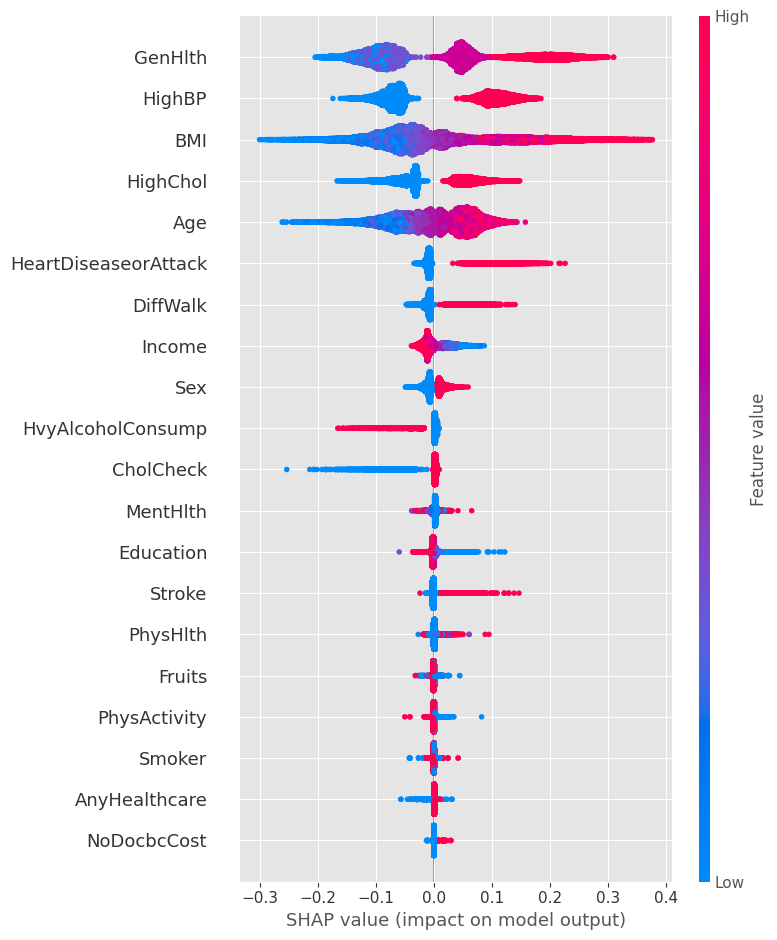

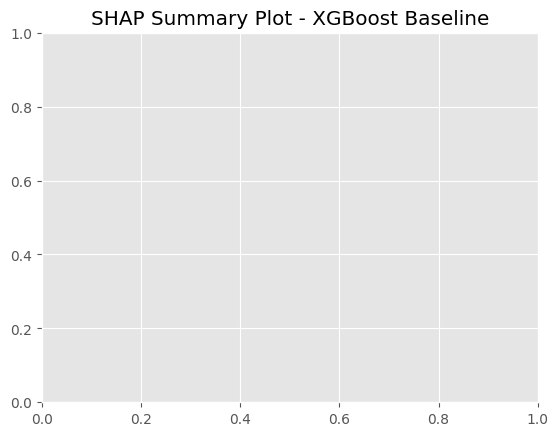

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


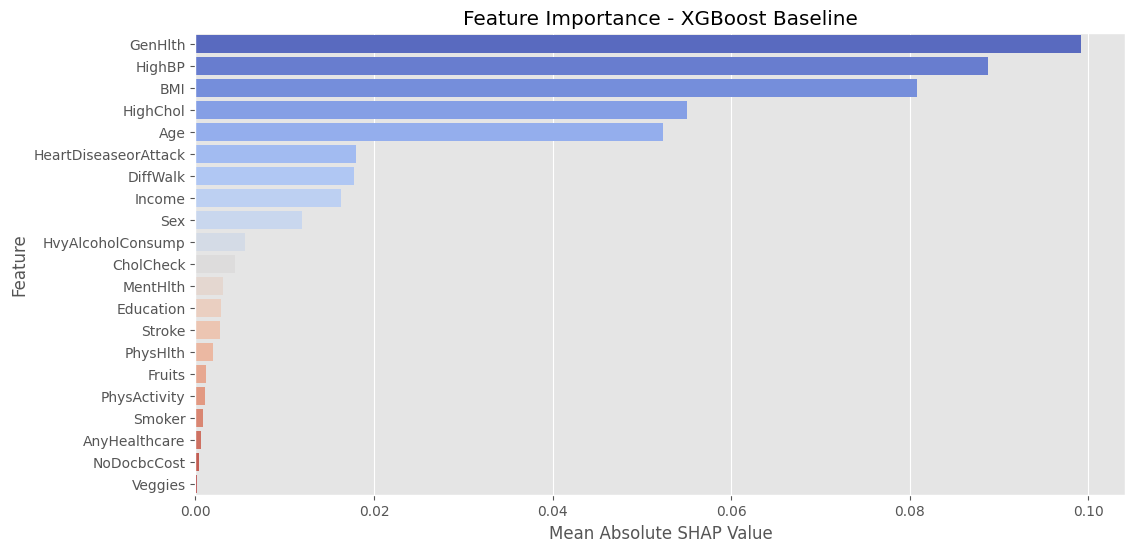


🔍 Running SHAP Analysis for XGBoost Feature Selection...


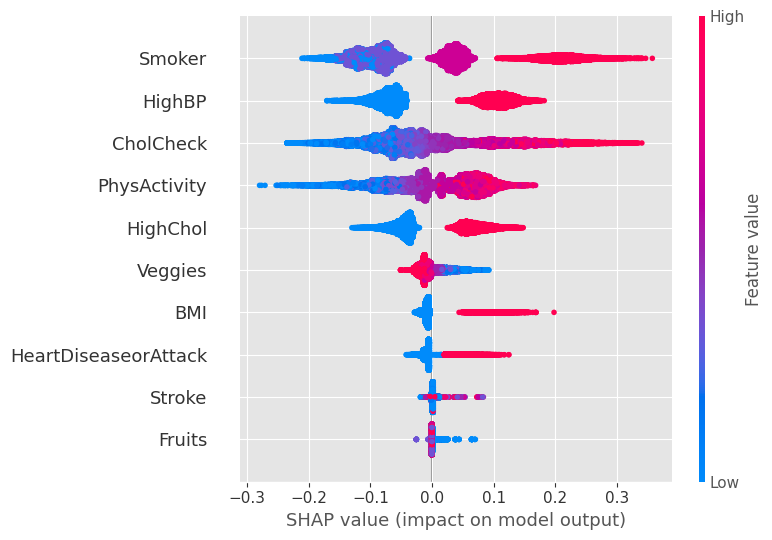

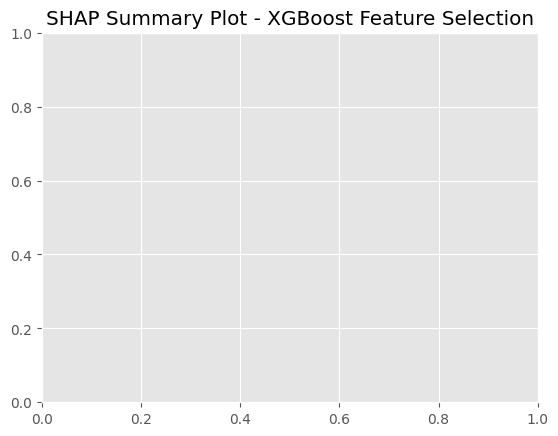

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


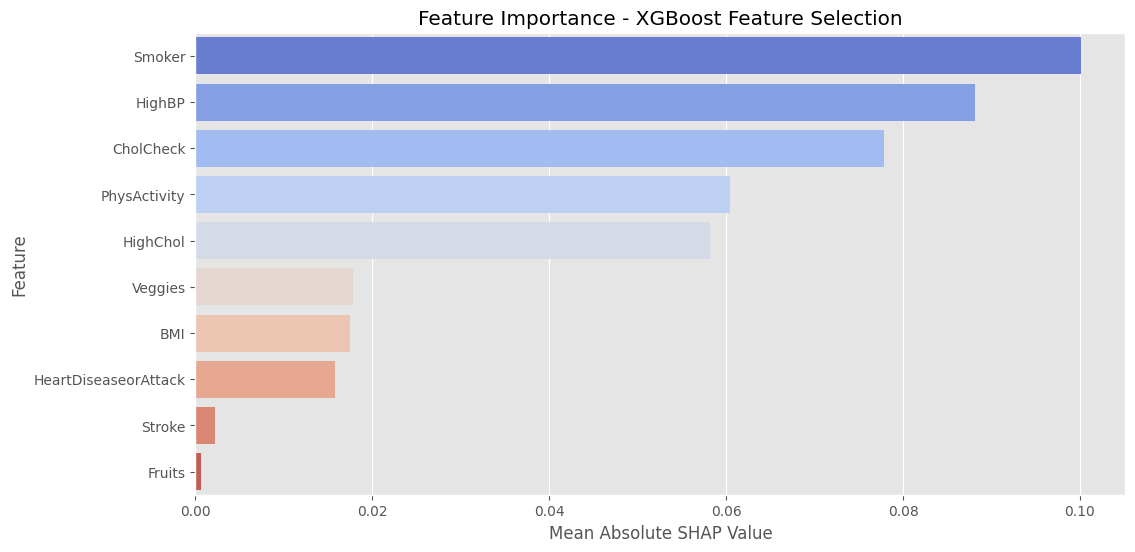


🔍 Running SHAP Analysis for XGBoost Feature Engineering...


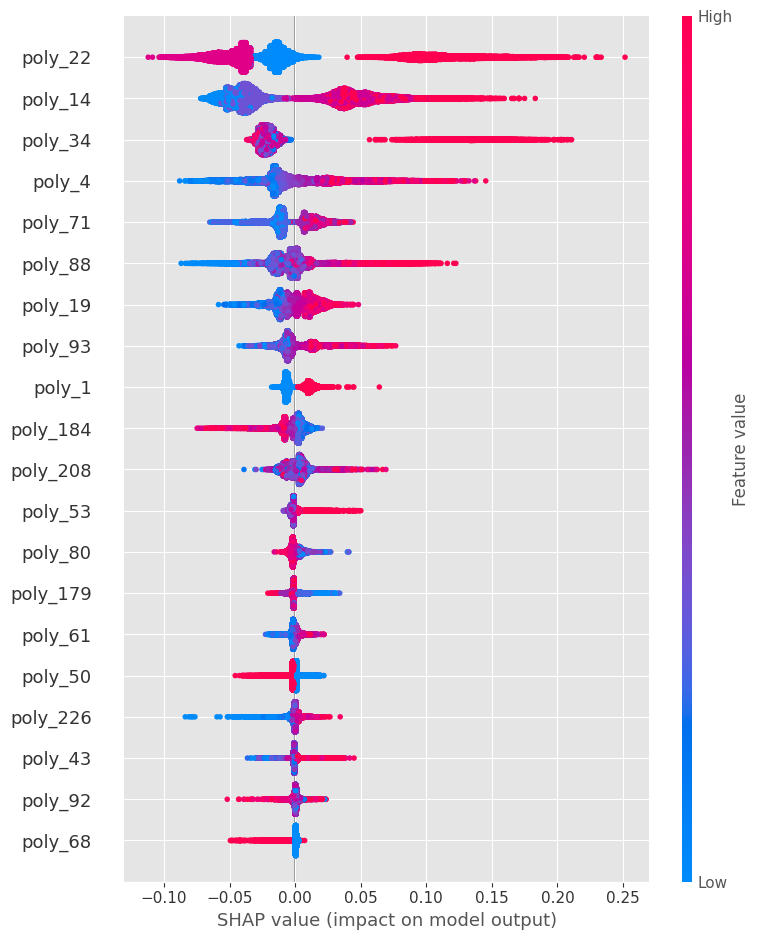

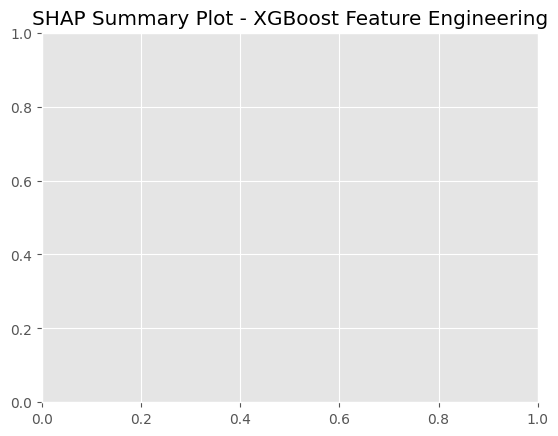

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


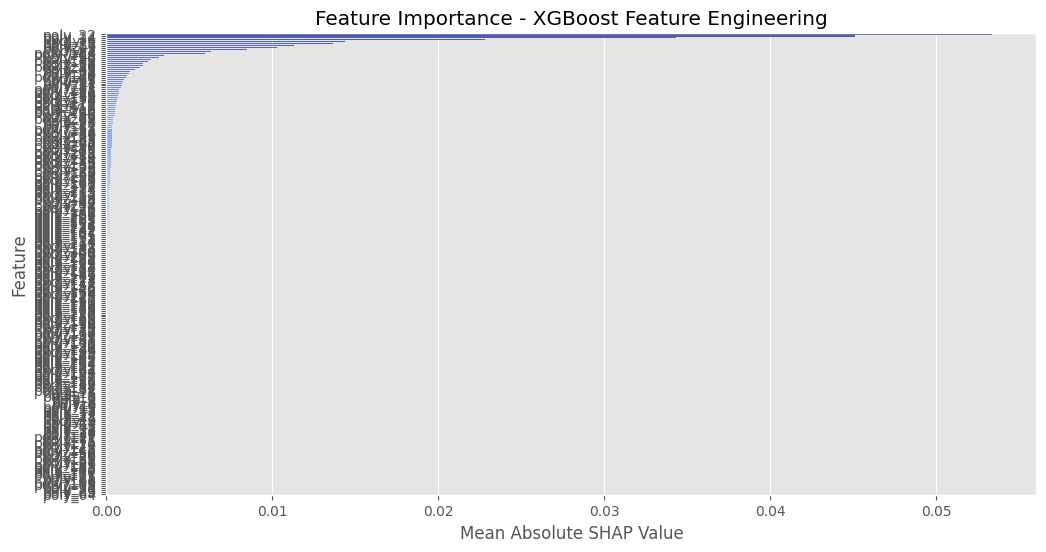


🔍 Running SHAP Analysis for LightGBM Baseline...
⚠ Multi-class detected in LightGBM Baseline, reducing SHAP values to 2D.


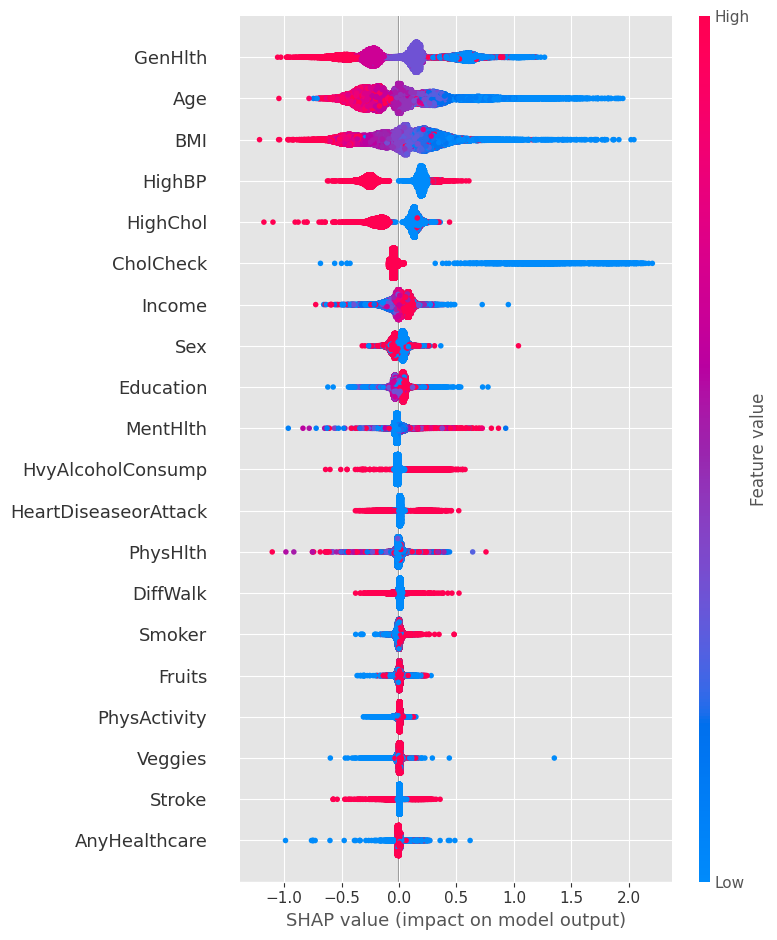

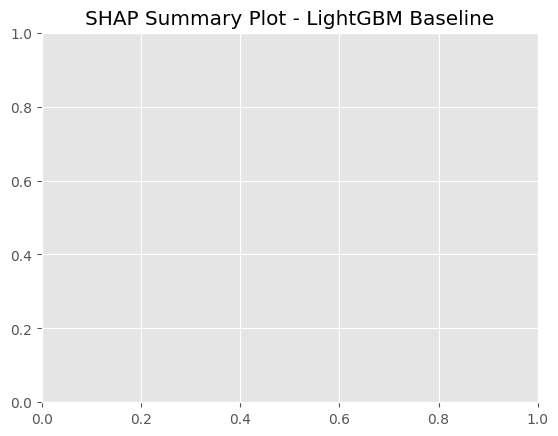

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


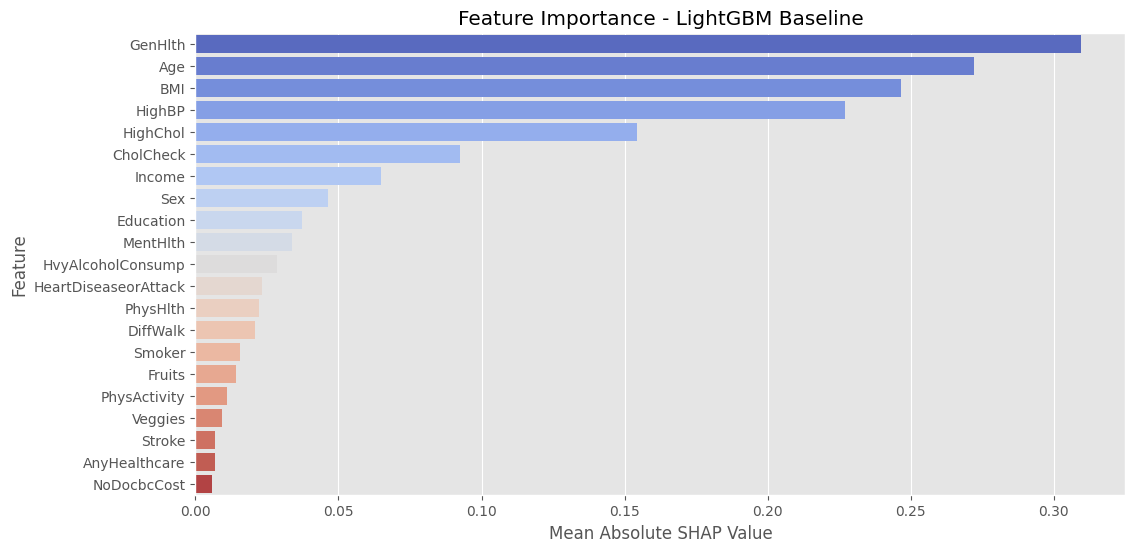


🔍 Running SHAP Analysis for LightGBM Feature Selection...
⚠ Multi-class detected in LightGBM Feature Selection, reducing SHAP values to 2D.


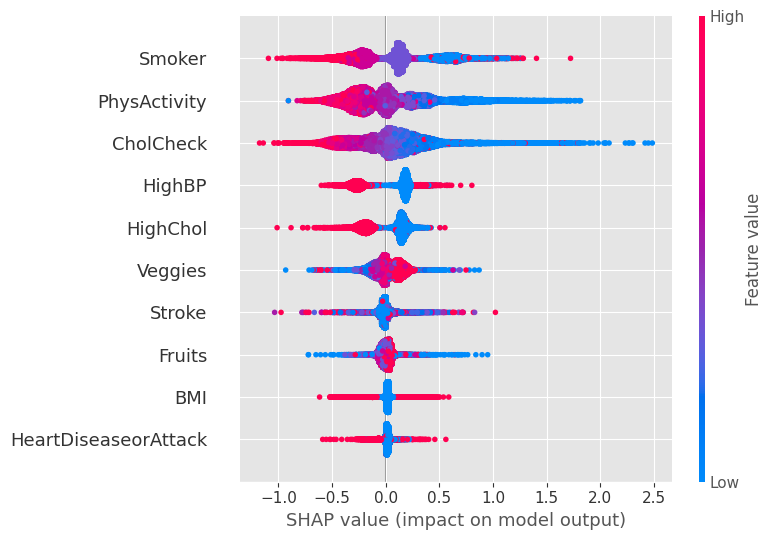

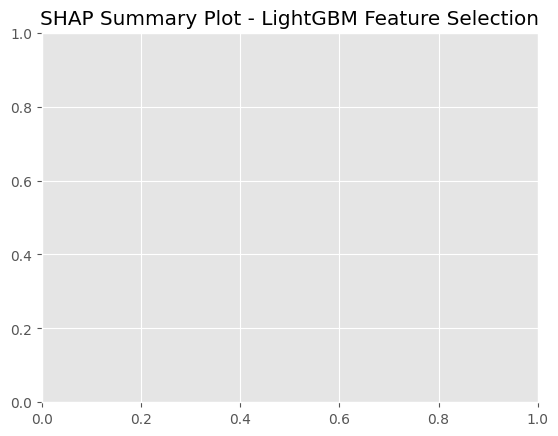

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


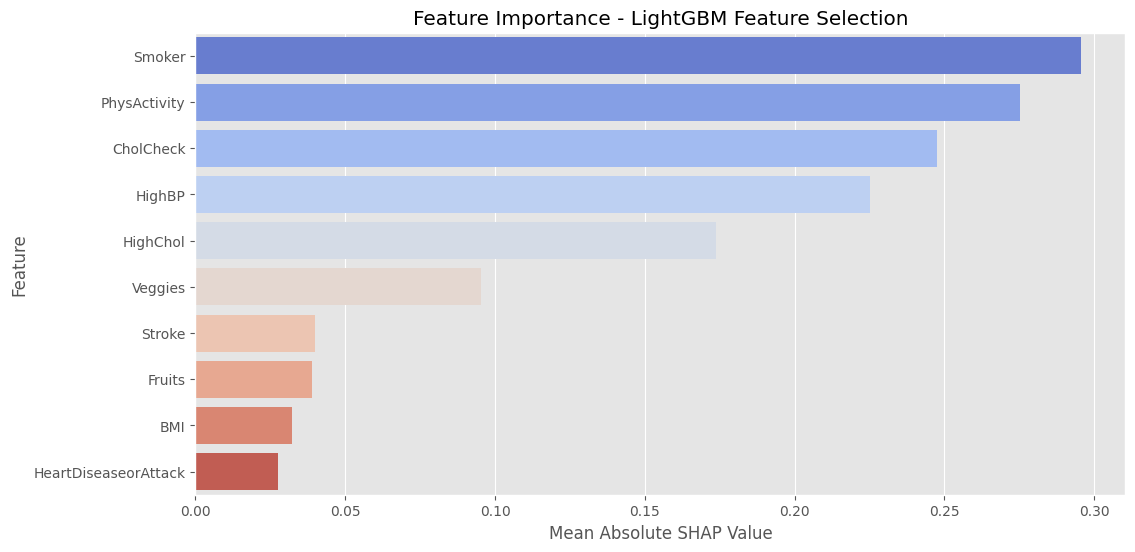


🔍 Running SHAP Analysis for LightGBM Feature Engineering...
⚠ Multi-class detected in LightGBM Feature Engineering, reducing SHAP values to 2D.


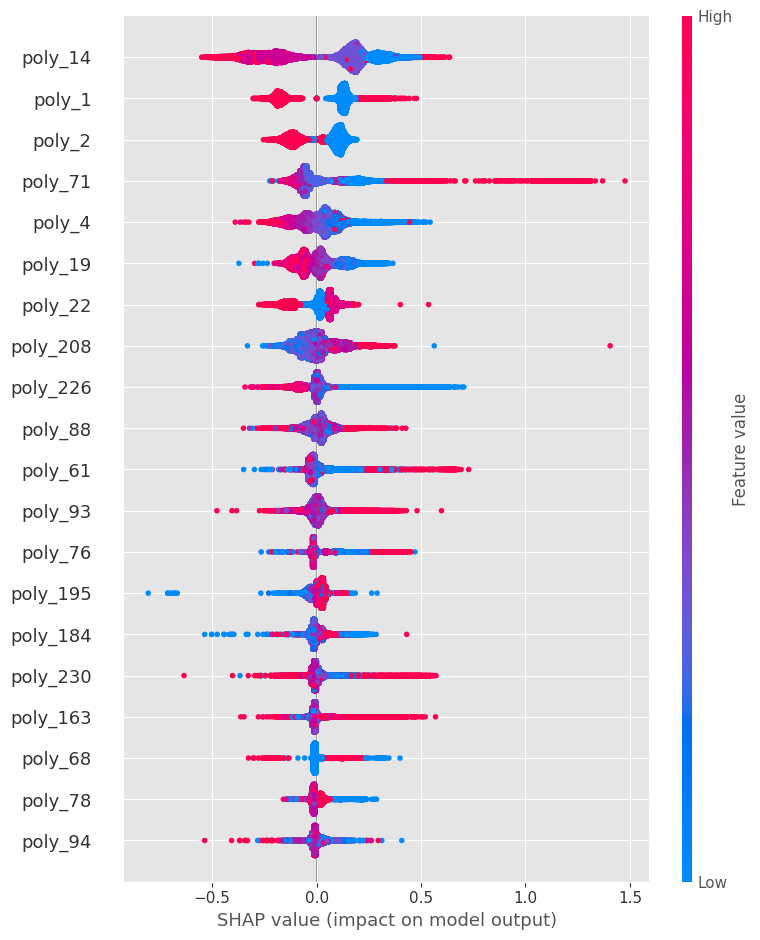

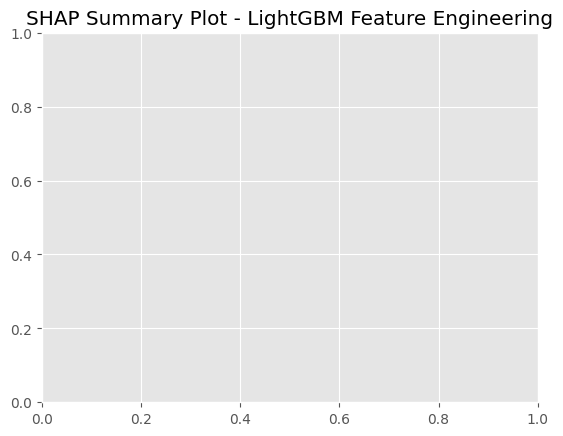

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


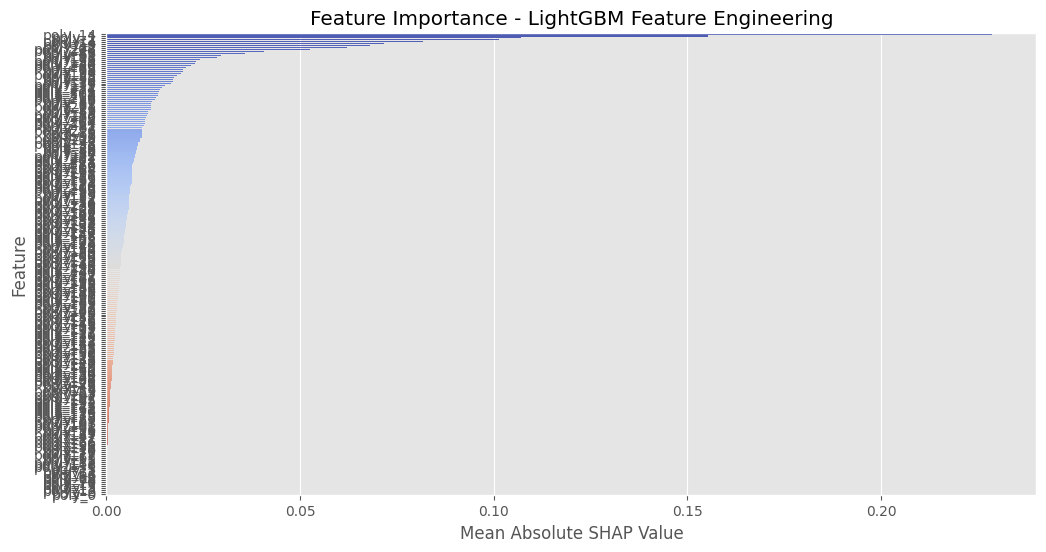


🔍 Running SHAP Analysis for CatBoost Baseline...
⚠ Multi-class detected in CatBoost Baseline, reducing SHAP values to 2D.


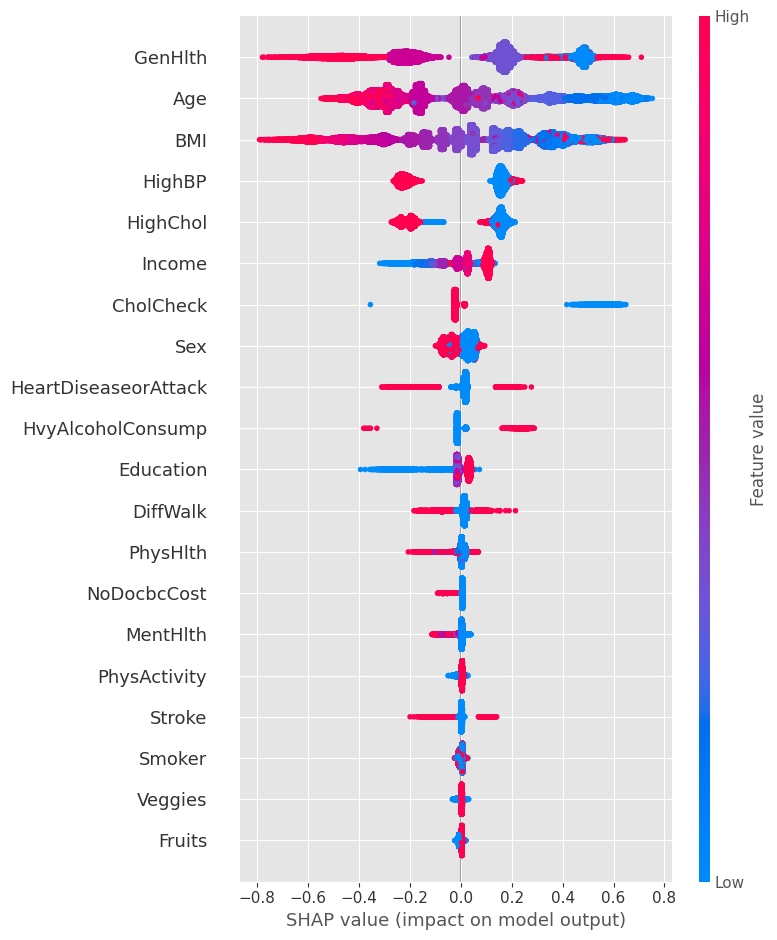

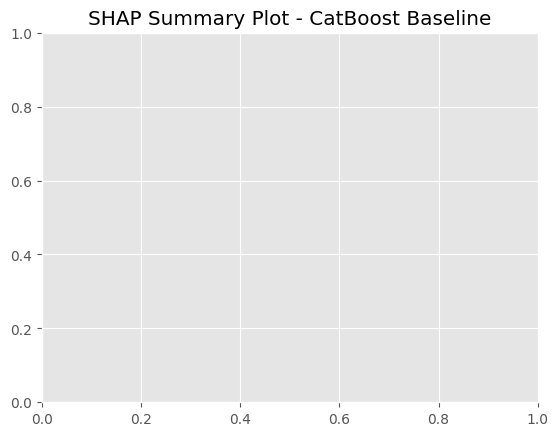

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


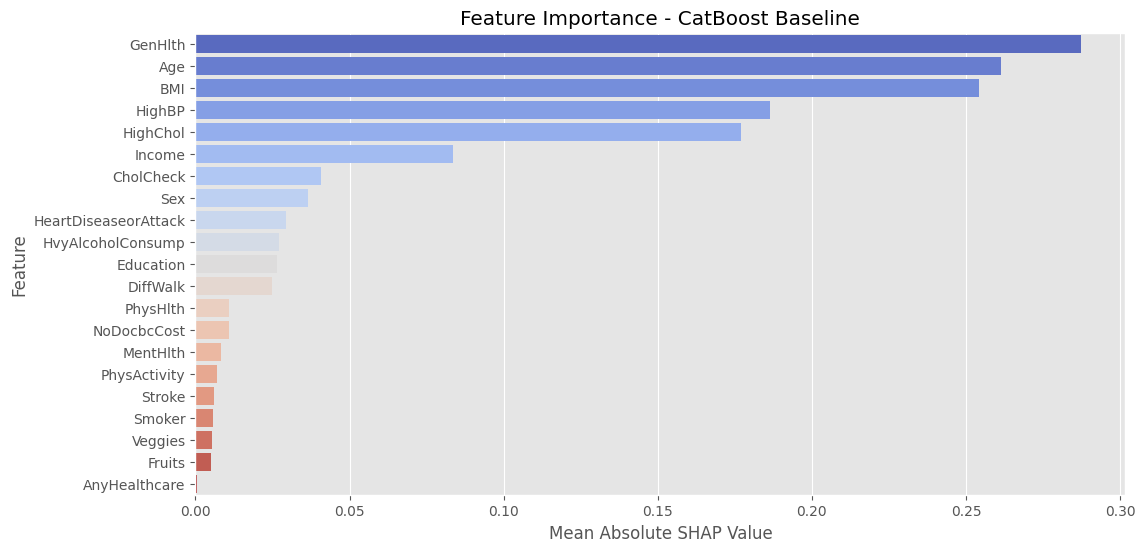


🔍 Running SHAP Analysis for CatBoost Feature Selection...
⚠ Multi-class detected in CatBoost Feature Selection, reducing SHAP values to 2D.


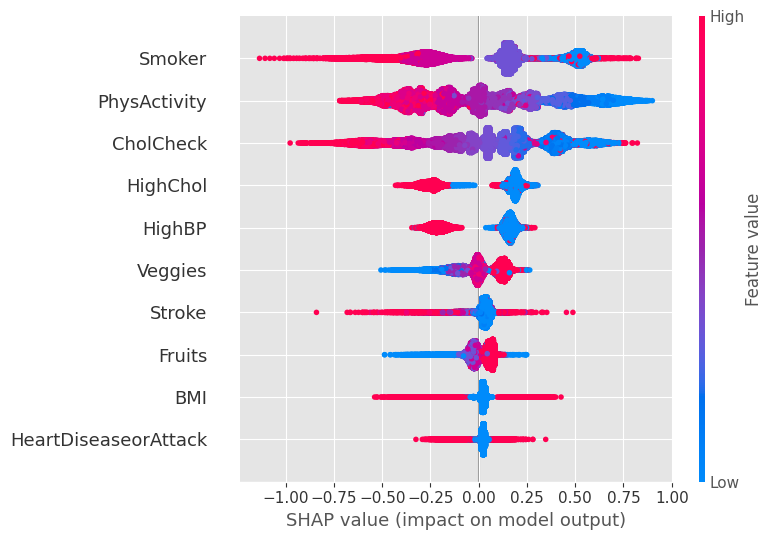

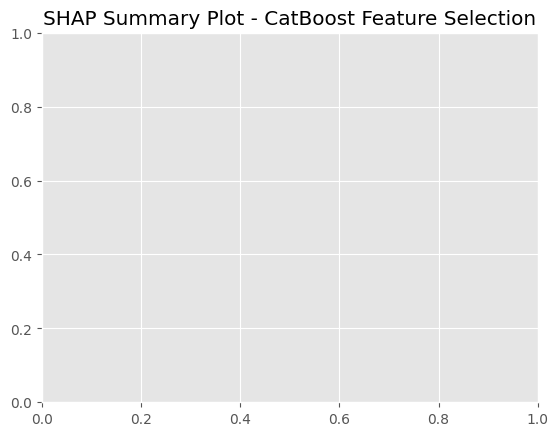

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


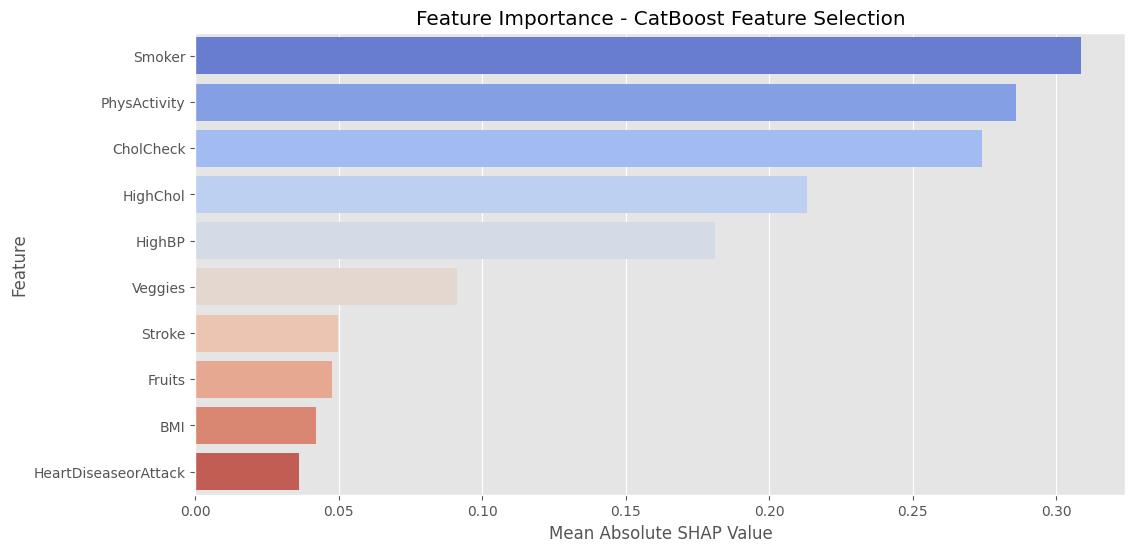


🔍 Running SHAP Analysis for CatBoost Feature Engineering...
⚠ Multi-class detected in CatBoost Feature Engineering, reducing SHAP values to 2D.


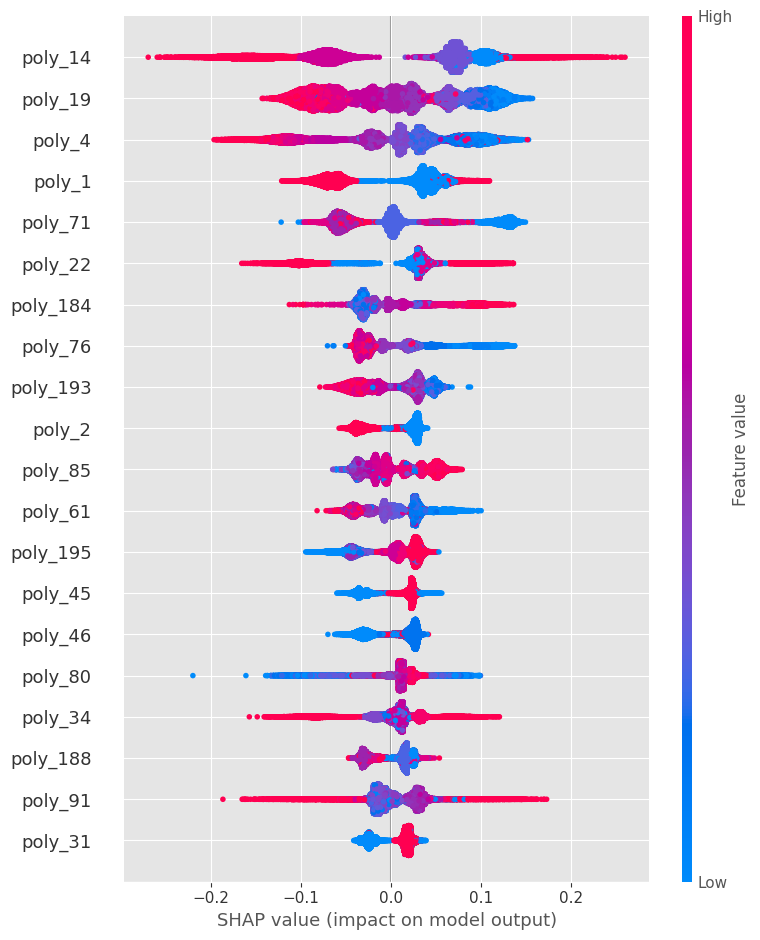

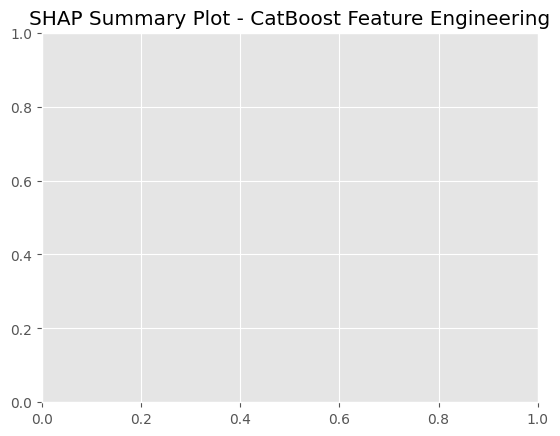

<ipython-input-18-5a5448c82ee3>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


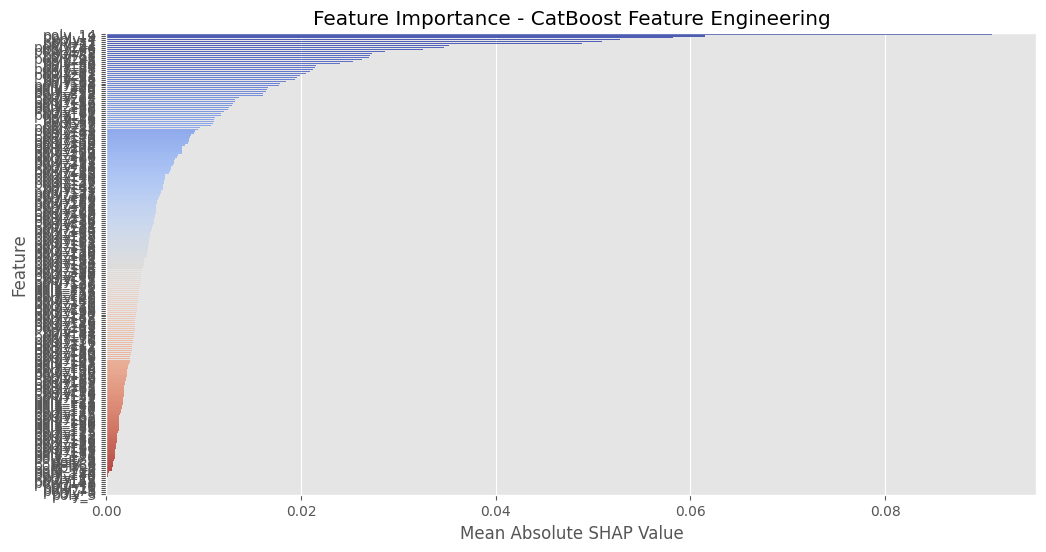

In [18]:
# SHAP Analysis After Optimization Using Optuna

# Install SHAP for Explainability
!pip install --quiet shap

# Import SHAP and visualization libraries
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set Matplotlib style
plt.style.use("ggplot")

# Convert NumPy arrays back to DataFrames with correct column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

X_train_fs_df = pd.DataFrame(X_train_fs, columns=X.columns[:X_train_fs.shape[1]])  # Selected features only
X_test_fs_df = pd.DataFrame(X_test_fs, columns=X.columns[:X_test_fs.shape[1]])

X_train_fe_df = pd.DataFrame(X_train_fe, columns=[f"poly_{i}" for i in range(X_train_fe.shape[1])])
X_test_fe_df = pd.DataFrame(X_test_fe, columns=[f"poly_{i}" for i in range(X_test_fe.shape[1])])

# Function to generate SHAP values and visualizations
def shap_analysis(model, X_train, X_test, model_name):
    print(f"\n🔍 Running SHAP Analysis for {model_name}...")

    # Check if it's XGBoost (requires DMatrix)
    if isinstance(model, xgb.Booster):
        explainer = shap.TreeExplainer(model)
        dtest = xgb.DMatrix(X_test)
        shap_values = explainer.shap_values(dtest)

    # Check if it's LightGBM
    elif isinstance(model, LGBMClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

    # Check if it's CatBoost
    elif isinstance(model, CatBoostClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

    else:
        print(f"⚠ SHAP analysis not supported for {model_name}")
        return

    # ======== 🔍 Fix for Multi-Class SHAP Values ========
    if isinstance(shap_values, list) or shap_values.ndim == 3:
        print(f"⚠ Multi-class detected in {model_name}, reducing SHAP values to 2D.")
        predicted_class = np.argmax(model.predict_proba(X_test), axis=1)  # Most confidently predicted class
        shap_values = np.array(shap_values)  # Convert to NumPy array if needed
        shap_values = shap_values[np.arange(len(predicted_class)), :, predicted_class]  # Select best class

    # Convert SHAP values to DataFrame
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)

    # ======== 🔍 SHAP Summary Plot ========
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)
    plt.title(f"SHAP Summary Plot - {model_name}")
    plt.show()

    # ======== 🔍 SHAP Feature Importance (Bar Chart) ========
    shap_importance = np.abs(shap_df).mean(axis=0).sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")
    plt.xlabel("Mean Absolute SHAP Value")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - {model_name}")
    plt.show()

# Fit models using best Optuna parameters
xgb_baseline_model = xgb.train(best_params["XGBoost_Baseline"], xgb.DMatrix(X_train_scaled, label=y_train))
xgb_fs_model = xgb.train(best_params["XGBoost_FeatureSelection"], xgb.DMatrix(X_train_fs, label=y_train))
xgb_fe_model = xgb.train(best_params["XGBoost_FeatureEngineering"], xgb.DMatrix(X_train_fe, label=y_train))

lgb_baseline_model = LGBMClassifier(**best_params["LightGBM_Baseline"]).fit(X_train_scaled, y_train)
lgb_fs_model = LGBMClassifier(**best_params["LightGBM_FeatureSelection"]).fit(X_train_fs, y_train)
lgb_fe_model = LGBMClassifier(**best_params["LightGBM_FeatureEngineering"]).fit(X_train_fe, y_train)

cat_baseline_model = CatBoostClassifier(**best_params["CatBoost_Baseline"], verbose=0).fit(X_train_scaled, y_train)
cat_fs_model = CatBoostClassifier(**best_params["CatBoost_FeatureSelection"], verbose=0).fit(X_train_fs, y_train)
cat_fe_model = CatBoostClassifier(**best_params["CatBoost_FeatureEngineering"], verbose=0).fit(X_train_fe, y_train)

# Run SHAP analysis on each optimized model
shap_analysis(xgb_baseline_model, X_train_scaled_df, X_test_scaled_df, "XGBoost Baseline")
shap_analysis(xgb_fs_model, X_train_fs_df, X_test_fs_df, "XGBoost Feature Selection")
shap_analysis(xgb_fe_model, X_train_fe_df, X_test_fe_df, "XGBoost Feature Engineering")

shap_analysis(lgb_baseline_model, X_train_scaled_df, X_test_scaled_df, "LightGBM Baseline")
shap_analysis(lgb_fs_model, X_train_fs_df, X_test_fs_df, "LightGBM Feature Selection")
shap_analysis(lgb_fe_model, X_train_fe_df, X_test_fe_df, "LightGBM Feature Engineering")

shap_analysis(cat_baseline_model, X_train_scaled_df, X_test_scaled_df, "CatBoost Baseline")
shap_analysis(cat_fs_model, X_train_fs_df, X_test_fs_df, "CatBoost Feature Selection")
shap_analysis(cat_fe_model, X_train_fe_df, X_test_fe_df, "CatBoost Feature Engineering")



📊 Optimized Model Performance Scores (After Optuna Tuning):
                         Model  F1 Score
0             XGBoost_Baseline  0.814556
1   XGBoost_FeatureEngineering  0.814333
2            LightGBM_Baseline  0.814088
3            CatBoost_Baseline  0.813099
4  LightGBM_FeatureEngineering  0.812605
5  CatBoost_FeatureEngineering  0.812559
6     XGBoost_FeatureSelection  0.811459
7    LightGBM_FeatureSelection  0.810081
8    CatBoost_FeatureSelection  0.809770

🏆 Best-performing model based on F1 Score: **XGBoost_Baseline** with F1 Score of **0.8146**


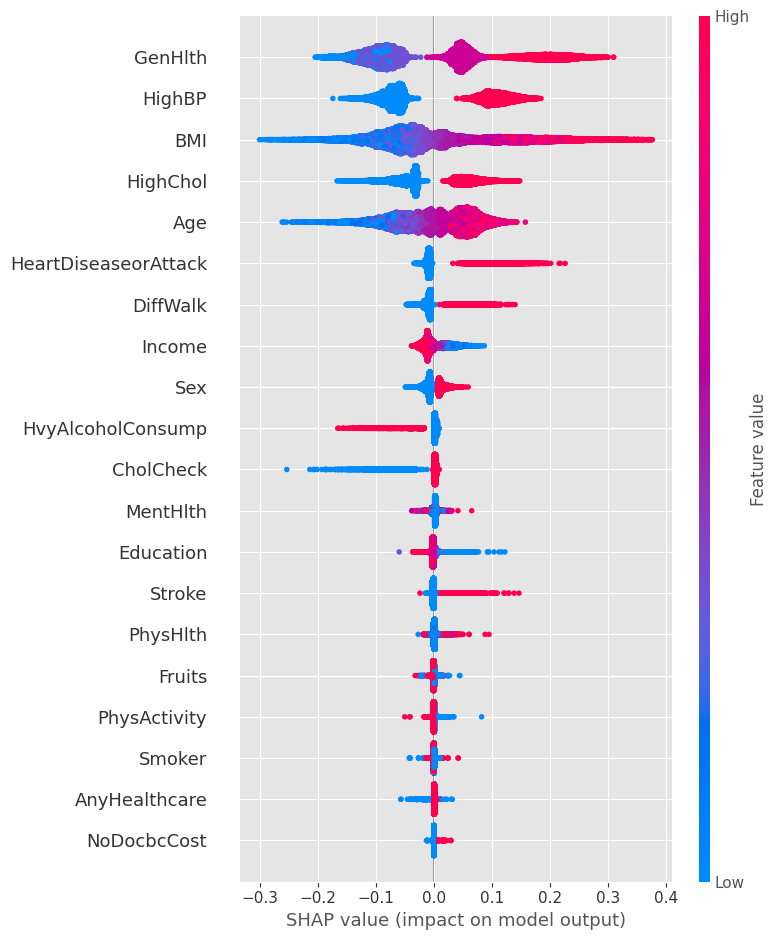

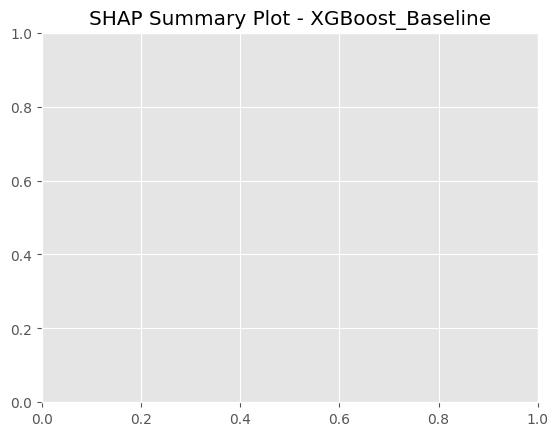

<ipython-input-20-b0c94ec88357>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")


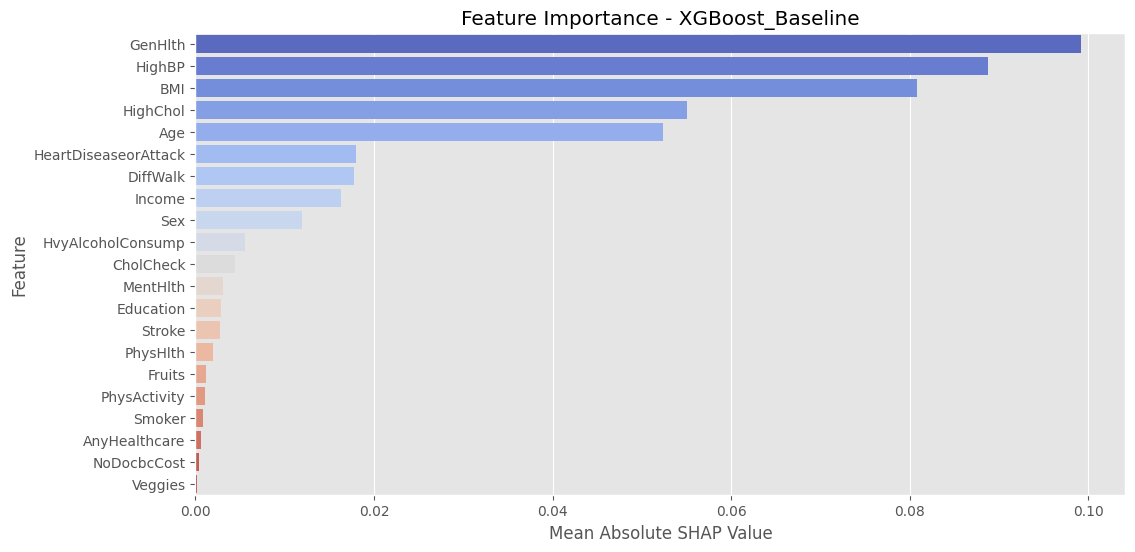

In [20]:
# Best Performing Model Based on SHAP Analysis After Optimization Using Optuna

# Install required packages
!pip install --quiet shap xgboost lightgbm catboost scikit-learn numpy matplotlib pandas seaborn

# Import necessary libraries
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import f1_score

# Set Matplotlib style
plt.style.use("ggplot")

# 🚨 Ensure the F1 scores are read correctly
f1_scores_df = pd.read_csv("optimized_f1_scores.csv")

# 🚨 Print F1 Scores for Debugging
print("\n📊 Optimized Model Performance Scores (After Optuna Tuning):")
print(f1_scores_df)

# ✅ Ensure Correct Sorting & Selection of the Best Model
f1_scores_df = f1_scores_df.sort_values(by="F1 Score", ascending=False, ignore_index=True)

# ✅ Force Selection of the Correct Best Model
best_model_f1 = f1_scores_df.iloc[0]["Model"]
best_f1_score = f1_scores_df.iloc[0]["F1 Score"]

# 🔥 Print Explicit Model Selection
print(f"\n🏆 Best-performing model based on F1 Score: **{best_model_f1}** with F1 Score of **{best_f1_score:.4f}**")

# 🔍 Ensure SHAP uses the **actual best model** based on F1 Score
best_model = best_model_f1

# ======== 🔍 SHAP Feature Importance Analysis (Ensuring Correct Model Selection) ========
if "XGBoost" in best_model:
    best_trained_model = xgb_baseline_model if "Baseline" in best_model else \
                         xgb_fs_model if "FeatureSelection" in best_model else xgb_fe_model
    best_X_test = X_test_scaled if "Baseline" in best_model else \
                  X_test_fs if "FeatureSelection" in best_model else X_test_fe
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(xgb.DMatrix(best_X_test))

elif "LightGBM" in best_model:
    best_trained_model = lgb_baseline_model if "Baseline" in best_model else \
                         lgb_fs_model if "FeatureSelection" in best_model else lgb_fe_model
    best_X_test = X_test_scaled if "Baseline" in best_model else \
                  X_test_fs if "FeatureSelection" in best_model else X_test_fe
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(best_X_test)

elif "CatBoost" in best_model:
    best_trained_model = cat_baseline_model if "Baseline" in best_model else \
                         cat_fs_model if "FeatureSelection" in best_model else cat_fe_model
    best_X_test = X_test_scaled if "Baseline" in best_model else \
                  X_test_fs if "FeatureSelection" in best_model else X_test_fe
    explainer = shap.TreeExplainer(best_trained_model)
    shap_values = explainer.shap_values(best_X_test)

# 🚀 Fix: Ensure best_X_test is a DataFrame before SHAP analysis
if isinstance(best_X_test, np.ndarray):
    best_X_test = pd.DataFrame(best_X_test, columns=X.columns[:best_X_test.shape[1]])

# ======== 🔍 Fix for Multi-Class SHAP Values ========
if isinstance(shap_values, list) or shap_values.ndim == 3:
    print(f"⚠ Multi-class detected in {best_model}, reducing SHAP values to 2D.")
    predicted_class = np.argmax(best_trained_model.predict_proba(best_X_test), axis=1)
    shap_values = np.array(shap_values)
    shap_values = shap_values[np.arange(len(predicted_class)), :, predicted_class]

# ✅ Fix: Convert SHAP values to DataFrame with correct column names
shap_df = pd.DataFrame(shap_values, columns=X.columns[:shap_values.shape[1]])

# ======== 🔍 SHAP Summary Plot ========
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, best_X_test, feature_names=X.columns[:shap_values.shape[1]])
plt.title(f"SHAP Summary Plot - {best_model}")
plt.show()

# ======== 🔍 SHAP Feature Importance (Bar Chart) ========
shap_importance = np.abs(shap_df).mean(axis=0).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=shap_importance.values, y=shap_importance.index, palette="coolwarm")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title(f"Feature Importance - {best_model}")
plt.show()



